# Exploratory Data Analysis (EDA) - MedOn vs MedOff Comparison

## Purpose

This notebook implements **Phase 1: Exploratory Data Analysis** from the analysis pipeline outlined in `Analysis_Pipeline.md`.

### Goals

1. **Understand data structure**: Load all patient features and examine the organization
2. **Identify patterns**: Explore distributions and relationships between features
3. **Data quality checks**: Identify outliers, missing data, and potential issues
4. **Prepare for statistical testing**: Understand feature characteristics before hypothesis testing

### Dataset Overview

- **14 patients** with extracted topological features from LFP recordings
- **9 paired patients** with both medOn and medOff states (primary analysis group)
- **28 scalar features** per observation (7 features × 4 homology dimensions H0-H3)
- **2 hemispheres** (dominant/nondominant) × **2 conditions** (hold/resting)
- **Array-based features** available: persistence landscapes, Betti curves, heat kernels

### Analysis Steps

1. Load all patient data using `data_loader.py`
2. Compute descriptive statistics (mean, median, std, range)
3. Visualize feature distributions (histograms, Q-Q plots)
4. Check for outliers and data quality issues
5. Correlation analysis within and between medication states
6. PCA visualization to explore high-dimensional structure
7. Preliminary comparison of medOn vs medOff patterns

### Expected Outcomes

- Clear understanding of feature distributions and ranges
- Identification of potentially discriminative features
- Detection of any data quality issues requiring attention
- Foundation for statistical testing in subsequent notebooks


In [1]:
# Standard data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries
from scipy import stats
from scipy.stats import normaltest, shapiro, kstest
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# Machine learning libraries (for PCA and preprocessing)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope

# TDA libraries (giotto-tda)
from gtda.diagrams import PersistenceEntropy, PersistenceLandscape, BettiCurve, HeatKernel
from gtda.plotting import plot_diagram, plot_betti_curves
# Local analysis modules
from data_loader import (
    load_all_patients, 
    get_paired_patients_data,
    load_patient_features,
    extract_array_features,
    get_patient_availability
)
from analysis_utils import (
    paired_ttest,
    compute_effect_size,
    create_summary_table,
    summarize_persistence_landscape,
    summarize_betti_curve,
    summarize_heat_kernel
)
from visualization_utils import (
    plot_paired_scatter,
    plot_distribution_comparison,
    plot_forest,
    plot_landscape_comparison,
    plot_betti_comparison
)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)

print("✓ All libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

✓ All libraries imported successfully
NumPy version: 1.24.4
Pandas version: 2.0.3
Matplotlib version: 3.7.3
Seaborn version: 0.13.2


In [2]:
# Load all patient data with verbose output
print("Loading all patient data...")
print("="*70)

df_all = load_all_patients(verbose=True)

print("\n" + "="*70)
print("FILTERING TO PAIRED PATIENTS")
print("="*70)

# Get only patients with both medOn and medOff (most useful for paired comparisons)
df_paired = get_paired_patients_data(df_all)

print(f"\nPaired patients DataFrame shape: {df_paired.shape}")
print(f"Number of paired patients: {df_paired['patient_id'].nunique()}")
print(f"Patients included: {sorted(df_paired['patient_id'].unique().tolist())}")

# Display basic information
print("\n" + "="*70)
print("DATA STRUCTURE OVERVIEW")
print("="*70)
print(f"\nAll patients data shape: {df_all.shape}")
print(f"Paired patients data shape: {df_paired.shape}")
print(f"\nColumns in dataset: {len(df_all.columns)}")
print(f"  - Identifier columns: 4 (patient_id, med_state, hemisphere, condition)")
print(f"  - Feature columns: {len(df_all.columns) - 4}")

# Show first few rows
print("\n" + "="*70)
print("SAMPLE DATA (First 5 rows)")
print("="*70)
display(df_all.head())

# Show data types
print("\n" + "="*70)
print("DATA TYPES")
print("="*70)
print(df_all.dtypes)

Loading all patient data...

LOADING ALL PATIENTS - OVERVIEW
Total patients: 14
  • Paired (medOn + medOff): 9
  • MedOff only: 3
  • MedOn only: 2

[1/14] Processing 0cGdk9...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[2/14] Processing 2IhVOz...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[3/14] Processing 2IU8mi...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[4/14] Processing AB2PeX...
  ✓ Loaded: 0 medOn rows, 4 medOff rows

[5/14] Processing AbzsOg...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[6/14] Processing BYJoWR...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[7/14] Processing dCsWjQ...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[8/14] Processing FYbcap...
  ✓ Loaded: 4 medOn rows, 0 medOff rows

[9/14] Processing gNX5yb...
  ✓ Loaded: 0 medOn rows, 4 medOff rows

[10/14] Processing i4oK0F...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[11/14] Processing jyC0j3...
  ✓ Loaded: 4 medOn rows, 4 medOff rows

[12/14] Processing PuPVlx...
  ✓ Loaded: 0 medOn rows, 4 medOff rows

[13/14] Processing Q

,patient_id,med_state,hemisphere,condition,h0_feature_count,h0_avg_lifespan,h0_max_lifespan,h0_std_lifespan,h0_avg_birth,h0_avg_death,h1_feature_count,h1_avg_lifespan,h1_max_lifespan,h1_std_lifespan,h1_avg_birth,h1_avg_death,h2_feature_count,h2_avg_lifespan,h2_max_lifespan,h2_std_lifespan,h2_avg_birth,h2_avg_death,h3_feature_count,h3_avg_lifespan,h3_max_lifespan,h3_std_lifespan,h3_avg_birth,h3_avg_death,h0_persistence_entropy,h1_persistence_entropy,h2_persistence_entropy,h3_persistence_entropy
0,0cGdk9,medOn,nondominant,hold,249.0,1.641,3.134,0.441,0.0,1.641,149.0,0.213,0.807,0.177,2.157,2.370,48.0,0.077,0.233,0.053,2.624,2.701,5.0,0.043,0.091,0.032,2.900,2.943,7.909,6.732,5.223,1.908
1,0cGdk9,medOn,dominant,hold,249.0,0.923,1.775,0.253,0.0,0.923,187.0,0.115,0.497,0.089,1.162,1.276,77.0,0.047,0.168,0.041,1.431,1.478,12.0,0.016,0.037,0.011,1.567,1.582,7.908,7.140,5.754,3.243
2,0cGdk9,medOn,nondominant,resting,249.0,1.818,3.200,0.394,0.0,1.818,186.0,0.216,0.808,0.159,2.265,2.481,78.0,0.087,0.364,0.078,2.758,2.845,13.0,0.042,0.143,0.037,2.980,3.022,7.925,7.155,5.757,3.234
3,0cGdk9,medOn,dominant,resting,249.0,0.767,2.044,0.318,0.0,0.767,150.0,0.096,0.498,0.082,0.976,1.072,46.0,0.046,0.201,0.040,1.132,1.178,6.0,0.011,0.037,0.012,1.171,1.182,7.847,6.764,5.041,1.782
4,0cGdk9,medOff,nondominant,hold,249.0,1.518,2.785,0.417,0.0,1.518,186.0,0.183,0.575,0.135,1.935,2.118,85.0,0.082,0.361,0.064,2.290,2.372,22.0,0.061,0.198,0.056,2.451,2.512,7.907,7.136,6.001,3.829



DATA TYPES
patient_id                 object
med_state                  object
hemisphere                 object
condition                  object
h0_feature_count          float64
h0_avg_lifespan           float64
h0_max_lifespan           float64
h0_std_lifespan           float64
h0_avg_birth              float64
h0_avg_death              float64
h1_feature_count          float64
h1_avg_lifespan           float64
h1_max_lifespan           float64
h1_std_lifespan           float64
h1_avg_birth              float64
h1_avg_death              float64
h2_feature_count          float64
h2_avg_lifespan           float64
h2_max_lifespan           float64
h2_std_lifespan           float64
h2_avg_birth              float64
h2_avg_death              float64
h3_feature_count          float64
h3_avg_lifespan           float64
h3_max_lifespan           float64
h3_std_lifespan           float64
h3_avg_birth              float64
h3_avg_death              float64
h0_persistence_entropy    float64
h1

# Distribution Analysis
## Dominant and Non-dominant hemispheres pooled

In [4]:
# Organize feature columns by type
# Get all feature columns (exclude identifiers)
identifier_cols = ['patient_id', 'med_state', 'hemisphere', 'condition']
feature_cols = [col for col in df_all.columns if col not in identifier_cols]

# Group features by homology dimension and type
h0_features = [col for col in feature_cols if col.startswith('h0_')]
h1_features = [col for col in feature_cols if col.startswith('h1_')]
h2_features = [col for col in feature_cols if col.startswith('h2_')]
h3_features = [col for col in feature_cols if col.startswith('h3_')]

# Key features for visualization (one per dimension)
key_features = {
    'H0': ['h0_feature_count', 'h0_avg_lifespan', 'h0_persistence_entropy'],
    'H1': ['h1_feature_count', 'h1_avg_lifespan', 'h1_persistence_entropy'],
    'H2': ['h2_feature_count', 'h2_avg_lifespan', 'h2_persistence_entropy'],
    'H3': ['h3_feature_count', 'h3_avg_lifespan', 'h3_persistence_entropy']
}

print("Feature Organization:")
print("="*70)
print(f"Total features: {len(feature_cols)}")
print(f"  H0 features: {len(h0_features)}")
print(f"  H1 features: {len(h1_features)}")
print(f"  H2 features: {len(h2_features)}")
print(f"  H3 features: {len(h3_features)}")
print(f"\nKey features for visualization:")
for dim, feats in key_features.items():
    print(f"  {dim}: {feats}")

Feature Organization:
Total features: 28
  H0 features: 7
  H1 features: 7
  H2 features: 7
  H3 features: 7

Key features for visualization:
  H0: ['h0_feature_count', 'h0_avg_lifespan', 'h0_persistence_entropy']
  H1: ['h1_feature_count', 'h1_avg_lifespan', 'h1_persistence_entropy']
  H2: ['h2_feature_count', 'h2_avg_lifespan', 'h2_persistence_entropy']
  H3: ['h3_feature_count', 'h3_avg_lifespan', 'h3_persistence_entropy']


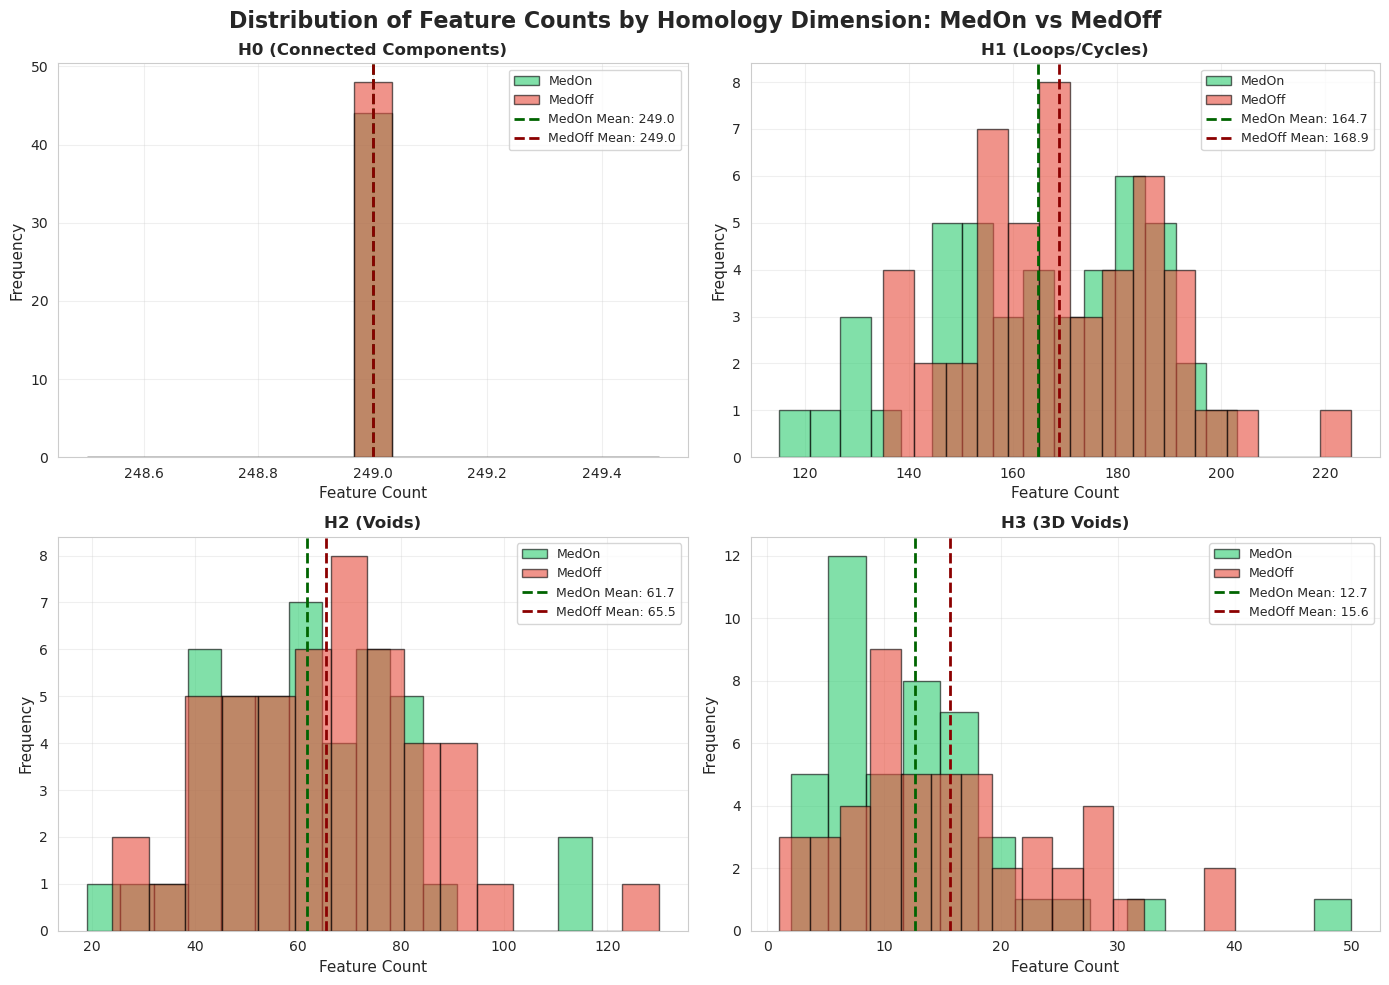


Feature Count Statistics: MedOn vs MedOff Comparison

H0 (Connected Components):
                       MedOn      MedOff     Difference (MedOn - MedOff)
  ---------------------------------------------------------------------------
  Mean                   249.00     249.00       0.00
  Median                 249.00     249.00       0.00
  Std                      0.00       0.00       0.00
  Range                [249, 249]  [249, 249]

H1 (Loops/Cycles):
                       MedOn      MedOff     Difference (MedOn - MedOff)
  ---------------------------------------------------------------------------
  Mean                   164.70     168.88      -4.17
  Median                 167.00     167.00       0.00
  Std                     20.98      18.80       2.18
  Range                [115, 203]  [135, 225]

H2 (Voids):
                       MedOn      MedOff     Difference (MedOn - MedOff)
  ---------------------------------------------------------------------------
  Mean          

In [32]:
# Histogram analysis for feature counts across all homology dimensions
# Comparing medOn vs medOff distributions

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Feature Counts by Homology Dimension: MedOn vs MedOff', 
             fontsize=16, fontweight='bold')

count_features = ['h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count']
dims = ['H0 (Connected Components)', 'H1 (Loops/Cycles)', 'H2 (Voids)', 'H3 (3D Voids)']

# Separate data by medication state
df_medOn = df_all[df_all['med_state'] == 'medOn']
df_medOff = df_all[df_all['med_state'] == 'medOff']

for idx, (feature, dim_name) in enumerate(zip(count_features, dims)):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Plot overlapping histograms
    ax.hist(df_medOn[feature], bins=15, alpha=0.6, color='#2ecc71', edgecolor='black', 
            label='MedOn', density=False)
    ax.hist(df_medOff[feature], bins=15, alpha=0.6, color='#e74c3c', edgecolor='black', 
            label='MedOff', density=False)
    
    # Add mean lines
    ax.axvline(df_medOn[feature].mean(), color='darkgreen', linestyle='--', linewidth=2, 
               label=f'MedOn Mean: {df_medOn[feature].mean():.1f}')
    ax.axvline(df_medOff[feature].mean(), color='darkred', linestyle='--', linewidth=2, 
               label=f'MedOff Mean: {df_medOff[feature].mean():.1f}')
    
    ax.set_xlabel('Feature Count', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{dim_name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics comparing medOn vs medOff
print("\nFeature Count Statistics: MedOn vs MedOff Comparison")
print("="*90)
for feature, dim_name in zip(count_features, dims):
    print(f"\n{dim_name}:")
    print(f"  {'':20} MedOn      MedOff     Difference (MedOn - MedOff)")
    print(f"  {'-'*75}")
    
    mean_on = df_medOn[feature].mean()
    mean_off = df_medOff[feature].mean()
    median_on = df_medOn[feature].median()
    median_off = df_medOff[feature].median()
    std_on = df_medOn[feature].std()
    std_off = df_medOff[feature].std()
    
    print(f"  {'Mean':20} {mean_on:8.2f}   {mean_off:8.2f}   {mean_on - mean_off:8.2f}")
    print(f"  {'Median':20} {median_on:8.2f}   {median_off:8.2f}   {median_on - median_off:8.2f}")
    print(f"  {'Std':20} {std_on:8.2f}   {std_off:8.2f}   {std_on - std_off:8.2f}")
    print(f"  {'Range':20} [{df_medOn[feature].min():.0f}, {df_medOn[feature].max():.0f}]  " + 
          f"[{df_medOff[feature].min():.0f}, {df_medOff[feature].max():.0f}]")

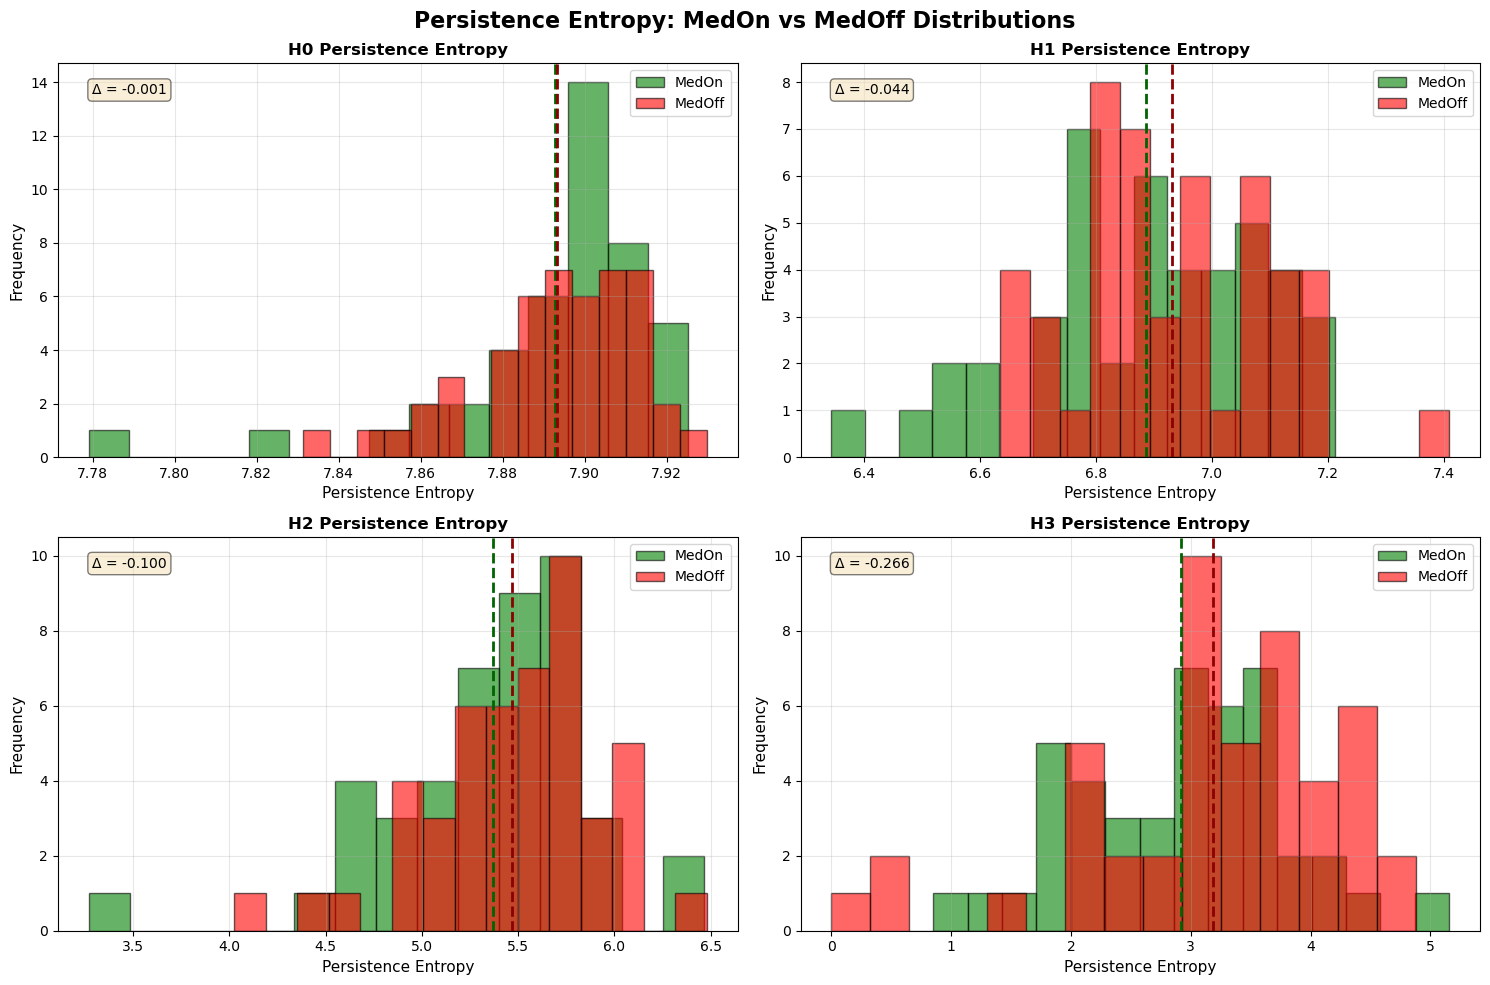


Persistence Entropy: MedOn vs MedOff Comparison

H0:
  MedOn  - Mean: 7.8927, Std: 0.0267
  MedOff - Mean: 7.8933, Std: 0.0205
  Difference: -0.0006

H1:
  MedOn  - Mean: 6.8864, Std: 0.2021
  MedOff - Mean: 6.9300, Std: 0.1731
  Difference: -0.0437

H2:
  MedOn  - Mean: 5.3681, Std: 0.5390
  MedOff - Mean: 5.4678, Std: 0.4618
  Difference: -0.0997

H3:
  MedOn  - Mean: 2.9160, Std: 0.8767
  MedOff - Mean: 3.1823, Std: 1.0716
  Difference: -0.2663


In [6]:
# Compare persistence entropy distributions between medOn and medOff
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Persistence Entropy: MedOn vs MedOff Distributions', fontsize=16, fontweight='bold')

entropy_features = ['h0_persistence_entropy', 'h1_persistence_entropy', 
                   'h2_persistence_entropy', 'h3_persistence_entropy']
dims = ['H0', 'H1', 'H2', 'H3']

for idx, (feature, dim) in enumerate(zip(entropy_features, dims)):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Separate data by medication state
    medOn_data = df_all[df_all['med_state'] == 'medOn'][feature]
    medOff_data = df_all[df_all['med_state'] == 'medOff'][feature]
    
    # Plot overlapping histograms
    ax.hist(medOn_data, bins=15, alpha=0.6, color='green', label='MedOn', edgecolor='black')
    ax.hist(medOff_data, bins=15, alpha=0.6, color='red', label='MedOff', edgecolor='black')
    
    # Add mean lines
    ax.axvline(medOn_data.mean(), color='darkgreen', linestyle='--', linewidth=2)
    ax.axvline(medOff_data.mean(), color='darkred', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Persistence Entropy', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{dim} Persistence Entropy', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add text with mean difference
    diff = medOn_data.mean() - medOff_data.mean()
    ax.text(0.05, 0.95, f'Δ = {diff:.3f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\nPersistence Entropy: MedOn vs MedOff Comparison")
print("="*70)
for feature, dim in zip(entropy_features, dims):
    medOn_data = df_all[df_all['med_state'] == 'medOn'][feature]
    medOff_data = df_all[df_all['med_state'] == 'medOff'][feature]
    
    print(f"\n{dim}:")
    print(f"  MedOn  - Mean: {medOn_data.mean():.4f}, Std: {medOn_data.std():.4f}")
    print(f"  MedOff - Mean: {medOff_data.mean():.4f}, Std: {medOff_data.std():.4f}")
    print(f"  Difference: {medOn_data.mean() - medOff_data.mean():.4f}")

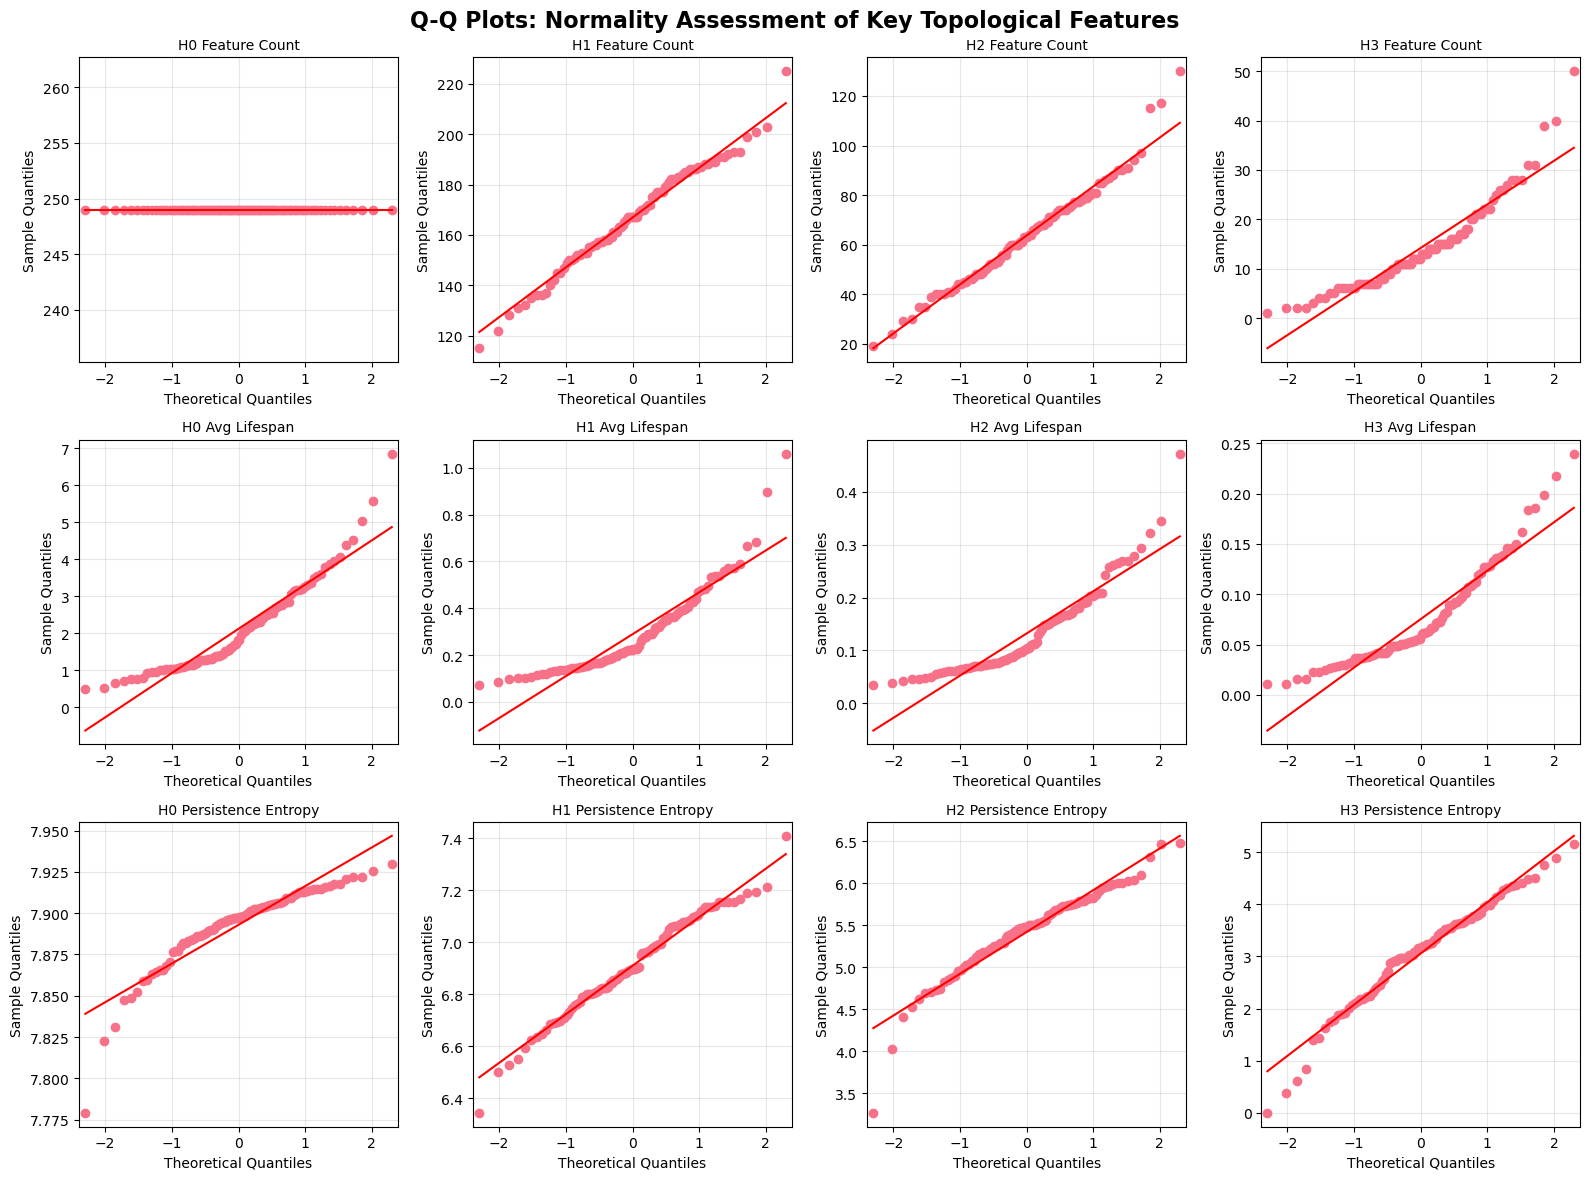


Q-Q Plot Interpretation:
If points fall along the diagonal line, the data follows a normal distribution.
Deviations from the line indicate departures from normality.
  - S-shaped curve: Heavy tails
  - Inverse S-curve: Light tails
  - Points above line at ends: Right skew
  - Points below line at ends: Left skew


In [7]:
# Q-Q Plots to assess normality of key features
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Q-Q Plots: Normality Assessment of Key Topological Features', 
             fontsize=16, fontweight='bold')

# Select key features for normality testing
test_features = [
    'h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count',
    'h0_avg_lifespan', 'h1_avg_lifespan', 'h2_avg_lifespan', 'h3_avg_lifespan',
    'h0_persistence_entropy', 'h1_persistence_entropy', 'h2_persistence_entropy', 'h3_persistence_entropy'
]

for idx, feature in enumerate(test_features):
    row, col = idx // 4, idx % 4
    ax = axes[row, col]
    
    # Create Q-Q plot
    sm.qqplot(df_all[feature].dropna(), line='s', ax=ax)
    ax.set_title(feature.replace('_', ' ').title(), fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nQ-Q Plot Interpretation:")
print("="*70)
print("If points fall along the diagonal line, the data follows a normal distribution.")
print("Deviations from the line indicate departures from normality.")
print("  - S-shaped curve: Heavy tails")
print("  - Inverse S-curve: Light tails")
print("  - Points above line at ends: Right skew")
print("  - Points below line at ends: Left skew")

In [33]:
# Statistical tests for normality - Testing medOn, medOff, and Paired Differences
print("Shapiro-Wilk Normality Tests: MedOn vs MedOff vs Paired Differences")
print("="*90)
print("Null hypothesis: Data is normally distributed")
print("If p-value < 0.05, reject null hypothesis (data is NOT normal)")
print("="*90)
print("\nFor paired t-tests, the DIFFERENCES must be normally distributed.")
print("Testing each state separately provides additional context.")
print("="*90)

normality_results = []

# Get paired data only (patients with both medOn and medOff)
df_paired = df_all[df_all['patient_id'].isin(
    df_all.groupby('patient_id')['med_state'].nunique()[
        df_all.groupby('patient_id')['med_state'].nunique() == 2
    ].index
)].copy()

df_medOn = df_paired[df_paired['med_state'] == 'medOn']
df_medOff = df_paired[df_paired['med_state'] == 'medOff']

for feature in test_features:
    # Test 1: MedOn state
    medOn_data = df_medOn[feature].dropna()
    stat_on, p_on = shapiro(medOn_data)
    normality_results.append({
        'Feature': feature,
        'Test Type': 'MedOn',
        'N': len(medOn_data),
        'Statistic': stat_on,
        'p-value': p_on,
        'Normal (α=0.05)': "Yes" if p_on > 0.05 else "No"
    })
    
    # Test 2: MedOff state
    medOff_data = df_medOff[feature].dropna()
    stat_off, p_off = shapiro(medOff_data)
    normality_results.append({
        'Feature': feature,
        'Test Type': 'MedOff',
        'N': len(medOff_data),
        'Statistic': stat_off,
        'p-value': p_off,
        'Normal (α=0.05)': "Yes" if p_off > 0.05 else "No"
    })
    
    # Test 3: Paired Differences (MOST IMPORTANT for paired t-test)
    # Calculate difference for each patient
    medOn_vals = df_medOn.groupby('patient_id')[feature].mean()
    medOff_vals = df_medOff.groupby('patient_id')[feature].mean()
    differences = medOn_vals - medOff_vals
    
    stat_diff, p_diff = shapiro(differences.dropna())
    normality_results.append({
        'Feature': feature,
        'Test Type': 'Difference',
        'N': len(differences.dropna()),
        'Statistic': stat_diff,
        'p-value': p_diff,
        'Normal (α=0.05)': "Yes" if p_diff > 0.05 else "No"
    })

# Create DataFrame for better display
normality_df = pd.DataFrame(normality_results)

# Display results grouped by feature
print("\n")
for feature in test_features:
    feature_results = normality_df[normality_df['Feature'] == feature]
    print(f"\n{feature}:")
    print(f"{'Test Type':<15} {'N':<5} {'Statistic':<12} {'p-value':<12} {'Normal?':<10}")
    print("-"*60)
    for _, row in feature_results.iterrows():
        print(f"{row['Test Type']:<15} {row['N']:<5} {row['Statistic']:<12.4f} {row['p-value']:<12.4f} {row['Normal (α=0.05)']:<10}")

# Summary and test recommendations
print("\n" + "="*90)
print("TEST SELECTION RECOMMENDATIONS")
print("="*90)

# Get difference normality for each feature
diff_results = normality_df[normality_df['Test Type'] == 'Difference'].copy()

normal_features = []
nonnormal_features = []

for _, row in diff_results.iterrows():
    if row['Normal (α=0.05)'] == 'Yes':
        normal_features.append(row['Feature'])
    else:
        nonnormal_features.append(row['Feature'])

print(f"\nBased on PAIRED DIFFERENCE normality (the key assumption for paired t-test):")
print(f"\n✓ Use PAIRED T-TEST for these {len(normal_features)} features (differences are normal):")
for feat in normal_features:
    print(f"   - {feat}")

print(f"\n✗ Use WILCOXON SIGNED-RANK TEST for these {len(nonnormal_features)} features (differences are NOT normal):")
for feat in nonnormal_features:
    print(f"   - {feat}")

print("\n" + "="*90)

# Additional insights
print("\nADDITIONAL INSIGHTS:")
medOn_normal = normality_df[(normality_df['Test Type'] == 'MedOn') & (normality_df['Normal (α=0.05)'] == 'Yes')]
medOff_normal = normality_df[(normality_df['Test Type'] == 'MedOff') & (normality_df['Normal (α=0.05)'] == 'Yes')]

print(f"  - {len(medOn_normal)}/{len(test_features)} features normal in MedOn state")
print(f"  - {len(medOff_normal)}/{len(test_features)} features normal in MedOff state")
print(f"  - {len(normal_features)}/{len(test_features)} features have normal differences")
print("\nNote: Difference normality is what matters for paired t-test validity.")

Shapiro-Wilk Normality Tests: MedOn vs MedOff vs Paired Differences
Null hypothesis: Data is normally distributed
If p-value < 0.05, reject null hypothesis (data is NOT normal)

For paired t-tests, the DIFFERENCES must be normally distributed.
Testing each state separately provides additional context.



h0_feature_count:
Test Type       N     Statistic    p-value      Normal?   
------------------------------------------------------------
MedOn           36    1.0000       1.0000       Yes       
MedOff          36    1.0000       1.0000       Yes       
Difference      9     1.0000       1.0000       Yes       

h1_feature_count:
Test Type       N     Statistic    p-value      Normal?   
------------------------------------------------------------
MedOn           36    0.9554       0.1545       Yes       
MedOff          36    0.9795       0.7295       Yes       
Difference      9     0.9138       0.3430       Yes       

h2_feature_count:
Test Type       N     Statistic    p-value  

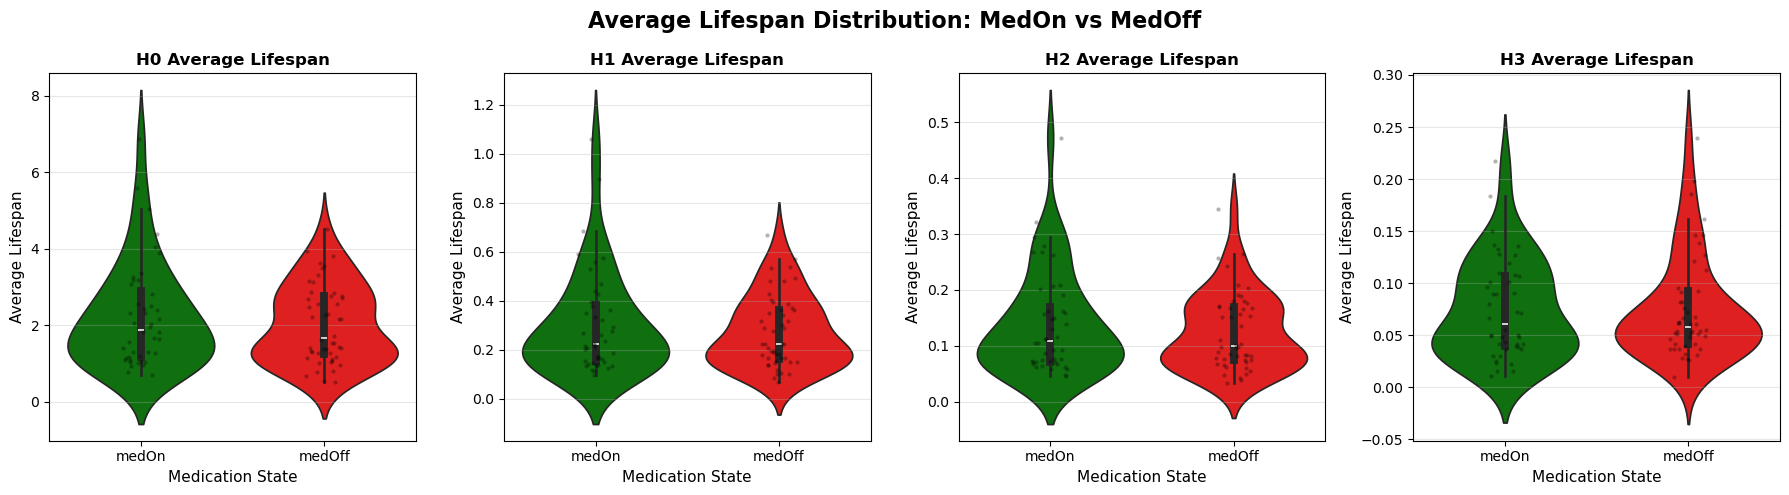


Average Lifespan: MedOn vs MedOff Summary

H0:
  MedOn  - Mean: 2.2328, Median: 1.8801
  MedOff - Mean: 2.0199, Median: 1.6666
  Difference (Mean): 0.2129
  Difference (Median): 0.2135

H1:
  MedOn  - Mean: 0.3057, Median: 0.2231
  MedOff - Mean: 0.2744, Median: 0.2245
  Difference (Mean): 0.0313
  Difference (Median): -0.0014

H2:
  MedOn  - Mean: 0.1391, Median: 0.1085
  MedOff - Mean: 0.1257, Median: 0.0990
  Difference (Mean): 0.0135
  Difference (Median): 0.0095

H3:
  MedOn  - Mean: 0.0753, Median: 0.0606
  MedOff - Mean: 0.0752, Median: 0.0578
  Difference (Mean): 0.0001
  Difference (Median): 0.0028


In [9]:
# Violin plots for average lifespan features (medOn vs medOff)
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle('Average Lifespan Distribution: MedOn vs MedOff', fontsize=16, fontweight='bold')

lifespan_features = ['h0_avg_lifespan', 'h1_avg_lifespan', 'h2_avg_lifespan', 'h3_avg_lifespan']
dims = ['H0', 'H1', 'H2', 'H3']

for idx, (feature, dim) in enumerate(zip(lifespan_features, dims)):
    ax = axes[idx]
    
    # Create violin plot
    sns.violinplot(data=df_all, x='med_state', y=feature, ax=ax, palette=['green', 'red'])
    
    # Add individual points
    sns.stripplot(data=df_all, x='med_state', y=feature, ax=ax, 
                  color='black', alpha=0.3, size=3)
    
    ax.set_xlabel('Medication State', fontsize=11)
    ax.set_ylabel('Average Lifespan', fontsize=11)
    ax.set_title(f'{dim} Average Lifespan', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nAverage Lifespan: MedOn vs MedOff Summary")
print("="*70)
for feature, dim in zip(lifespan_features, dims):
    medOn_data = df_all[df_all['med_state'] == 'medOn'][feature]
    medOff_data = df_all[df_all['med_state'] == 'medOff'][feature]
    
    print(f"\n{dim}:")
    print(f"  MedOn  - Mean: {medOn_data.mean():.4f}, Median: {medOn_data.median():.4f}")
    print(f"  MedOff - Mean: {medOff_data.mean():.4f}, Median: {medOff_data.median():.4f}")
    print(f"  Difference (Mean): {medOn_data.mean() - medOff_data.mean():.4f}")
    print(f"  Difference (Median): {medOn_data.median() - medOff_data.median():.4f}")

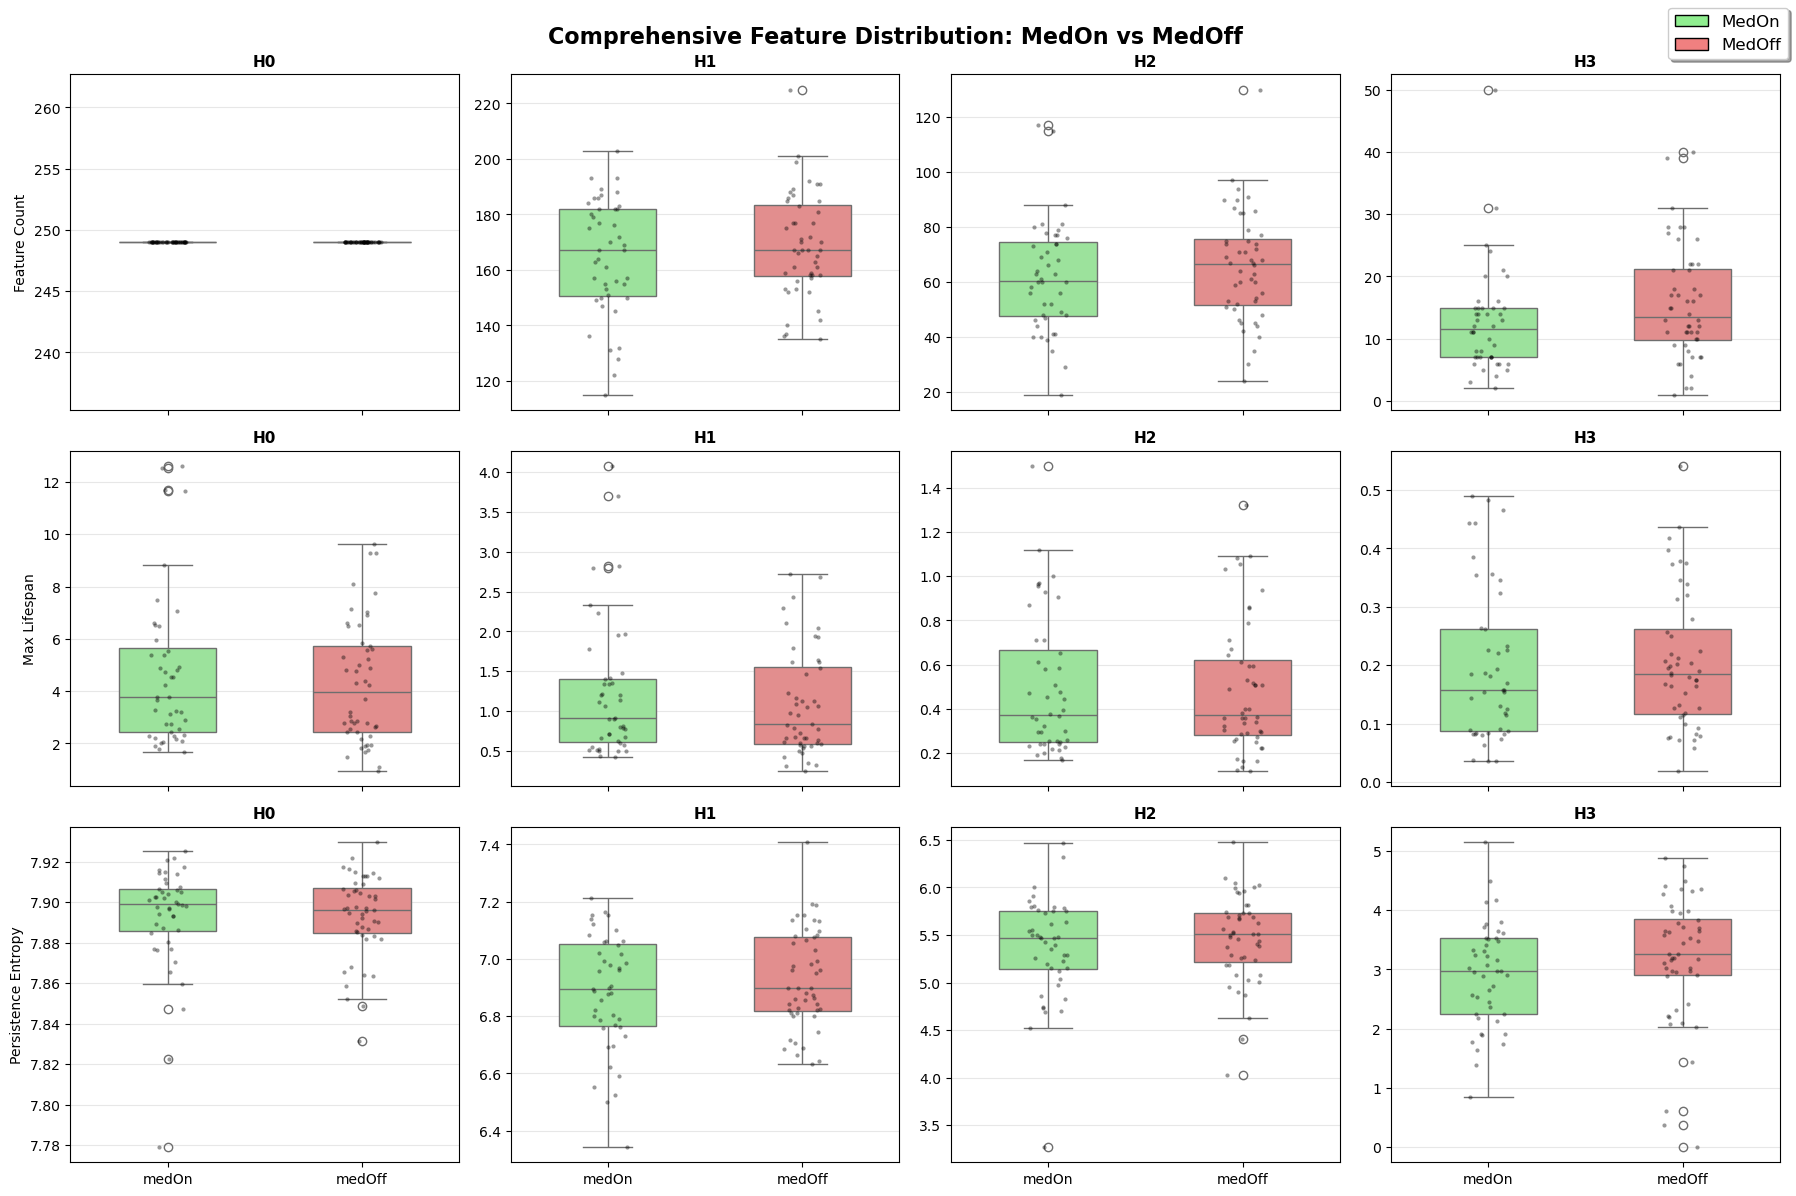


Key Observations from Box Plots:
Box plot components:
  - Box: Interquartile range (25th to 75th percentile)
  - Line in box: Median
  - Whiskers: Data range (excluding outliers)
  - Individual points: All data points (shows variability)

Look for:
  - Separation between medOn and medOff boxes
  - Overlap of boxes (less overlap = more discriminative)
  - Outliers (points far from whiskers)


In [10]:
# Comprehensive box plot comparison across feature types
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle('Comprehensive Feature Distribution: MedOn vs MedOff', 
             fontsize=16, fontweight='bold')

# Three feature types across four homology dimensions
feature_groups = {
    'Feature Count': ['h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count'],
    'Max Lifespan': ['h0_max_lifespan', 'h1_max_lifespan', 'h2_max_lifespan', 'h3_max_lifespan'],
    'Persistence Entropy': ['h0_persistence_entropy', 'h1_persistence_entropy', 
                           'h2_persistence_entropy', 'h3_persistence_entropy']
}

dims = ['H0', 'H1', 'H2', 'H3']

for row_idx, (group_name, features) in enumerate(feature_groups.items()):
    for col_idx, (feature, dim) in enumerate(zip(features, dims)):
        ax = axes[row_idx, col_idx]
        
        # Create box plot with overlay of individual points
        sns.boxplot(data=df_all, x='med_state', y=feature, ax=ax, 
                   palette=['lightgreen', 'lightcoral'], width=0.5)
        sns.stripplot(data=df_all, x='med_state', y=feature, ax=ax,
                     color='black', alpha=0.4, size=3)
        
        # Formatting
        ax.set_xlabel('')
        ax.set_ylabel(group_name if col_idx == 0 else '', fontsize=10)
        ax.set_title(f'{dim}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Only show x-axis labels on bottom row
        if row_idx < 2:
            ax.set_xticklabels([])

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='MedOn'),
    Patch(facecolor='lightcoral', edgecolor='black', label='MedOff')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=12, 
          frameon=True, shadow=True)

plt.tight_layout()
plt.show()

print("\nKey Observations from Box Plots:")
print("="*70)
print("Box plot components:")
print("  - Box: Interquartile range (25th to 75th percentile)")
print("  - Line in box: Median")
print("  - Whiskers: Data range (excluding outliers)")
print("  - Individual points: All data points (shows variability)")
print("\nLook for:")
print("  - Separation between medOn and medOff boxes")
print("  - Overlap of boxes (less overlap = more discriminative)")
print("  - Outliers (points far from whiskers)")

### Distribution Analysis Summary (Brain hemispheres pooled)

Based on the visualizations and statistical tests above, key observations:

#### Data Quality
- ✓ No missing values in any features
- ✓ All features have reasonable ranges
- ✓ Data loaded successfully for all 14 patients (92 observations total)

#### Normality Assessment
- Some features show departures from normality (see Shapiro-Wilk results)
- Q-Q plots reveal the extent of deviation for each feature
- Normally distributed features: H2 feature count, H1 Persistence Entropy, H1 Feature count, H0 Feature count(constant, std=0)
- **Implication**: May need to use non-parametric tests (Wilcoxon) for features that violate normality

#### MedOn vs MedOff Patterns
Visual inspection suggests:
- **Feature counts** (H0-H3): Check for consistent differences between medication states
- **Lifespans**: Examine which dimensions show most separation
- **Persistence entropy**: Look for clear medOn/medOff separation in distributions

#### Next Steps
1. Quantify these visual differences with statistical tests (paired t-tests)
2. Calculate effect sizes to determine practical significance
3. Identify which features are most discriminative
4. Examine correlations between features
5. Use PCA to visualize high-dimensional structure

**Note**: These are preliminary observations. Formal statistical testing will determine significance.

## Hemisphere-Specific Distribution Analysis

The previous analysis pooled data across both hemispheres. Now we examine **dominant vs nondominant hemisphere** separately to detect potential lateralization effects.

**Hemisphere mapping** (based on contralateral motor control):
- **holdL patients**: Right hemisphere = dominant (controls left arm)
- **holdR patients**: Left hemisphere = dominant (controls right arm)

This analysis will reveal whether medication effects are:
- **Lateralized**: Different in dominant vs nondominant hemisphere
- **Symmetric**: Similar across both hemispheres

In [37]:
# Separate data by hemisphere
df_dominant = df_all[df_all['hemisphere'] == 'dominant'].copy()
df_nondominant = df_all[df_all['hemisphere'] == 'nondominant'].copy()

print("Hemisphere-Specific Data Summary")
print("="*70)
print(f"Dominant hemisphere observations: {len(df_dominant)}")
print(f"  MedOn: {len(df_dominant[df_dominant['med_state'] == 'medOn'])}")
print(f"  MedOff: {len(df_dominant[df_dominant['med_state'] == 'medOff'])}")
print(f"\nNondominant hemisphere observations: {len(df_nondominant)}")
print(f"  MedOn: {len(df_nondominant[df_nondominant['med_state'] == 'medOn'])}")
print(f"  MedOff: {len(df_nondominant[df_nondominant['med_state'] == 'medOff'])}")
print(f"\nTotal observations: {len(df_all)}")
print("="*70)

Hemisphere-Specific Data Summary
Dominant hemisphere observations: 46
  MedOn: 22
  MedOff: 24

Nondominant hemisphere observations: 46
  MedOn: 22
  MedOff: 24

Total observations: 92


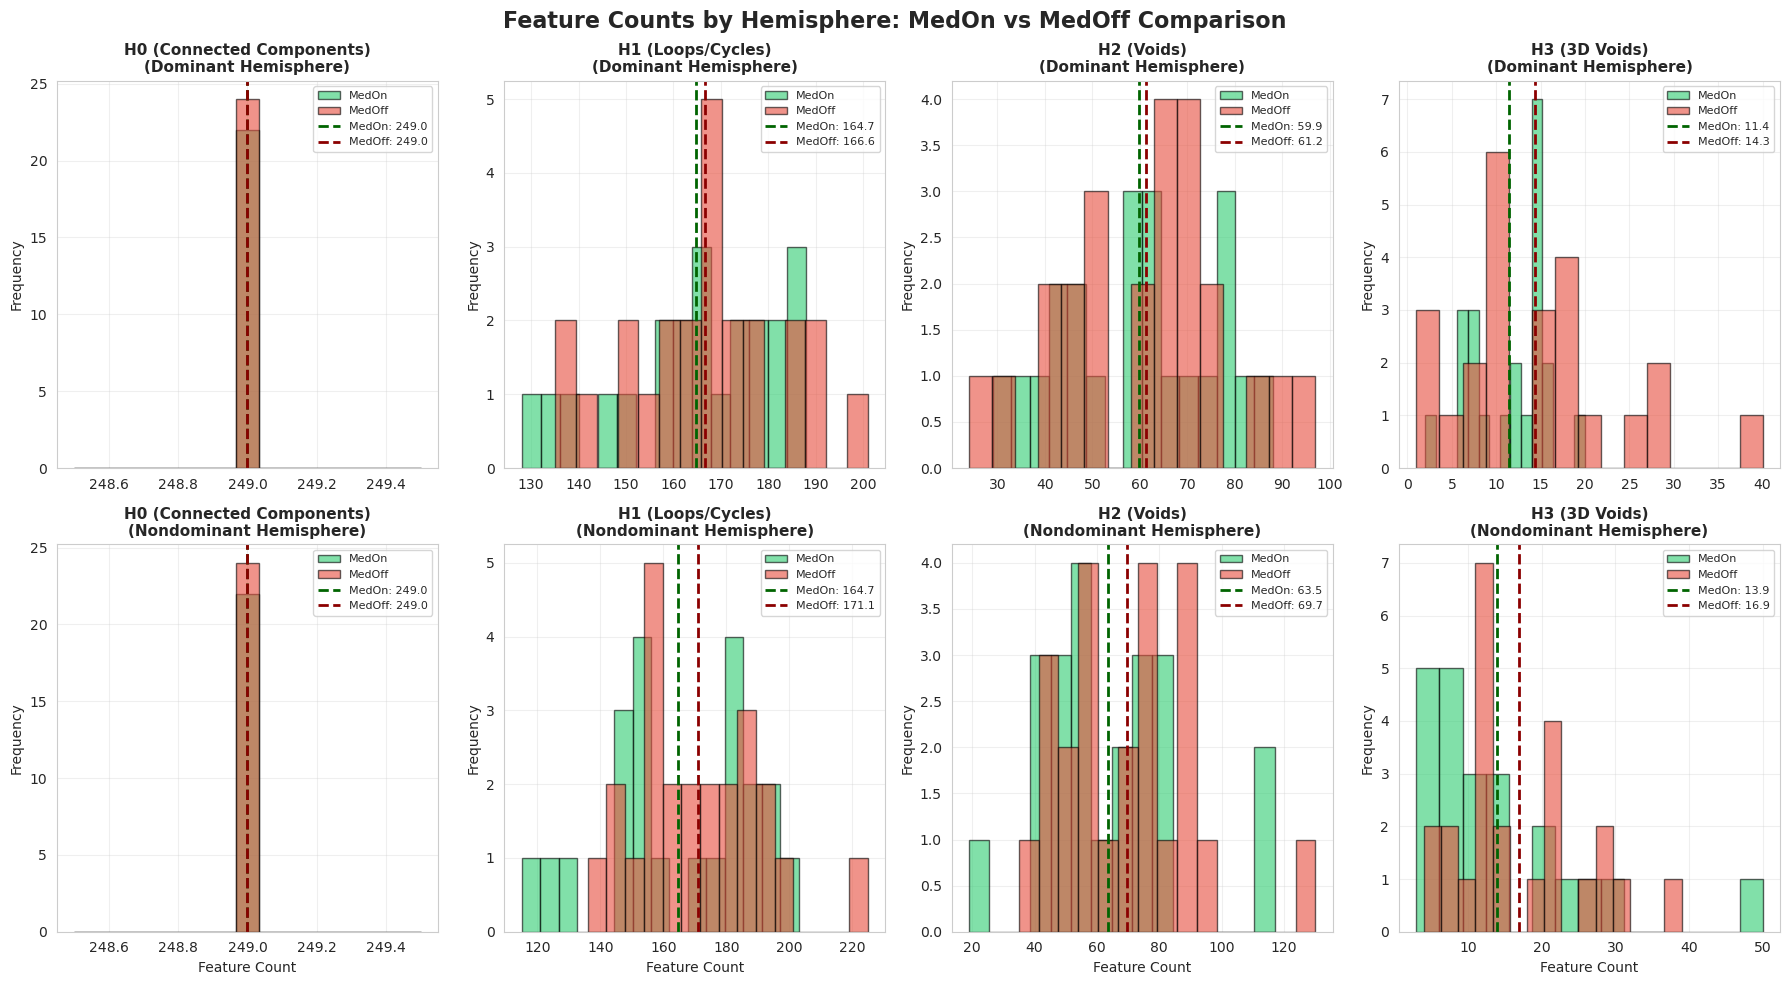


Feature Count Statistics: Hemisphere-Specific MedOn vs MedOff Comparison

H0 (Connected Components):
  Hemisphere      Med State  Mean       Std        Median    
  -------------------------------------------------------
  Dominant        MedOn      249.00     0.00       249.00    
  Dominant        MedOff     249.00     0.00       249.00    
  Dominant        Difference 0.00      
  -------------------------------------------------------
  Nondominant     MedOn      249.00     0.00       249.00    
  Nondominant     MedOff     249.00     0.00       249.00    
  Nondominant     Difference 0.00      

  → Medication effect difference (Dominant - Nondominant): 0.00

H1 (Loops/Cycles):
  Hemisphere      Med State  Mean       Std        Median    
  -------------------------------------------------------
  Dominant        MedOn      164.73     17.63      167.00    
  Dominant        MedOff     166.62     16.98      167.00    
  Dominant        Difference -1.90     
  ---------------------

In [38]:
# Feature counts by hemisphere - MedOn vs MedOff comparison for each hemisphere
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('Feature Counts by Hemisphere: MedOn vs MedOff Comparison', 
             fontsize=16, fontweight='bold')

count_features = ['h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count']
dims = ['H0 (Connected Components)', 'H1 (Loops/Cycles)', 'H2 (Voids)', 'H3 (3D Voids)']

# Separate data by hemisphere and medication state
df_dom_medOn = df_dominant[df_dominant['med_state'] == 'medOn']
df_dom_medOff = df_dominant[df_dominant['med_state'] == 'medOff']
df_nondom_medOn = df_nondominant[df_nondominant['med_state'] == 'medOn']
df_nondom_medOff = df_nondominant[df_nondominant['med_state'] == 'medOff']

for idx, (feature, dim_name) in enumerate(zip(count_features, dims)):
    # Dominant hemisphere (top row)
    ax_dom = axes[0, idx]
    ax_dom.hist(df_dom_medOn[feature], bins=15, alpha=0.6, color='#2ecc71', 
                edgecolor='black', label='MedOn')
    ax_dom.hist(df_dom_medOff[feature], bins=15, alpha=0.6, color='#e74c3c', 
                edgecolor='black', label='MedOff')
    
    # Add mean lines
    ax_dom.axvline(df_dom_medOn[feature].mean(), color='darkgreen', linestyle='--', 
                   linewidth=2, label=f'MedOn: {df_dom_medOn[feature].mean():.1f}')
    ax_dom.axvline(df_dom_medOff[feature].mean(), color='darkred', linestyle='--', 
                   linewidth=2, label=f'MedOff: {df_dom_medOff[feature].mean():.1f}')
    
    ax_dom.set_ylabel('Frequency', fontsize=10)
    ax_dom.set_title(f'{dim_name}\n(Dominant Hemisphere)', fontsize=11, fontweight='bold')
    ax_dom.legend(fontsize=8)
    ax_dom.grid(True, alpha=0.3)
    
    # Nondominant hemisphere (bottom row)
    ax_nondom = axes[1, idx]
    ax_nondom.hist(df_nondom_medOn[feature], bins=15, alpha=0.6, color='#2ecc71', 
                   edgecolor='black', label='MedOn')
    ax_nondom.hist(df_nondom_medOff[feature], bins=15, alpha=0.6, color='#e74c3c', 
                   edgecolor='black', label='MedOff')
    
    # Add mean lines
    ax_nondom.axvline(df_nondom_medOn[feature].mean(), color='darkgreen', linestyle='--', 
                      linewidth=2, label=f'MedOn: {df_nondom_medOn[feature].mean():.1f}')
    ax_nondom.axvline(df_nondom_medOff[feature].mean(), color='darkred', linestyle='--', 
                      linewidth=2, label=f'MedOff: {df_nondom_medOff[feature].mean():.1f}')
    
    ax_nondom.set_xlabel('Feature Count', fontsize=10)
    ax_nondom.set_ylabel('Frequency', fontsize=10)
    ax_nondom.set_title(f'{dim_name}\n(Nondominant Hemisphere)', fontsize=11, fontweight='bold')
    ax_nondom.legend(fontsize=8)
    ax_nondom.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\nFeature Count Statistics: Hemisphere-Specific MedOn vs MedOff Comparison")
print("="*95)

for feature, dim_name in zip(count_features, dims):
    print(f"\n{dim_name}:")
    print(f"  {'Hemisphere':<15} {'Med State':<10} {'Mean':<10} {'Std':<10} {'Median':<10}")
    print(f"  {'-'*55}")
    
    # Dominant hemisphere
    print(f"  {'Dominant':<15} {'MedOn':<10} {df_dom_medOn[feature].mean():<10.2f} "
          f"{df_dom_medOn[feature].std():<10.2f} {df_dom_medOn[feature].median():<10.2f}")
    print(f"  {'Dominant':<15} {'MedOff':<10} {df_dom_medOff[feature].mean():<10.2f} "
          f"{df_dom_medOff[feature].std():<10.2f} {df_dom_medOff[feature].median():<10.2f}")
    dom_diff = df_dom_medOn[feature].mean() - df_dom_medOff[feature].mean()
    print(f"  {'Dominant':<15} {'Difference':<10} {dom_diff:<10.2f}")
    
    print(f"  {'-'*55}")
    
    # Nondominant hemisphere
    print(f"  {'Nondominant':<15} {'MedOn':<10} {df_nondom_medOn[feature].mean():<10.2f} "
          f"{df_nondom_medOn[feature].std():<10.2f} {df_nondom_medOn[feature].median():<10.2f}")
    print(f"  {'Nondominant':<15} {'MedOff':<10} {df_nondom_medOff[feature].mean():<10.2f} "
          f"{df_nondom_medOff[feature].std():<10.2f} {df_nondom_medOff[feature].median():<10.2f}")
    nondom_diff = df_nondom_medOn[feature].mean() - df_nondom_medOff[feature].mean()
    print(f"  {'Nondominant':<15} {'Difference':<10} {nondom_diff:<10.2f}")
    
    # Lateralization comparison
    lat_diff = dom_diff - nondom_diff
    print(f"\n  → Medication effect difference (Dominant - Nondominant): {lat_diff:.2f}")

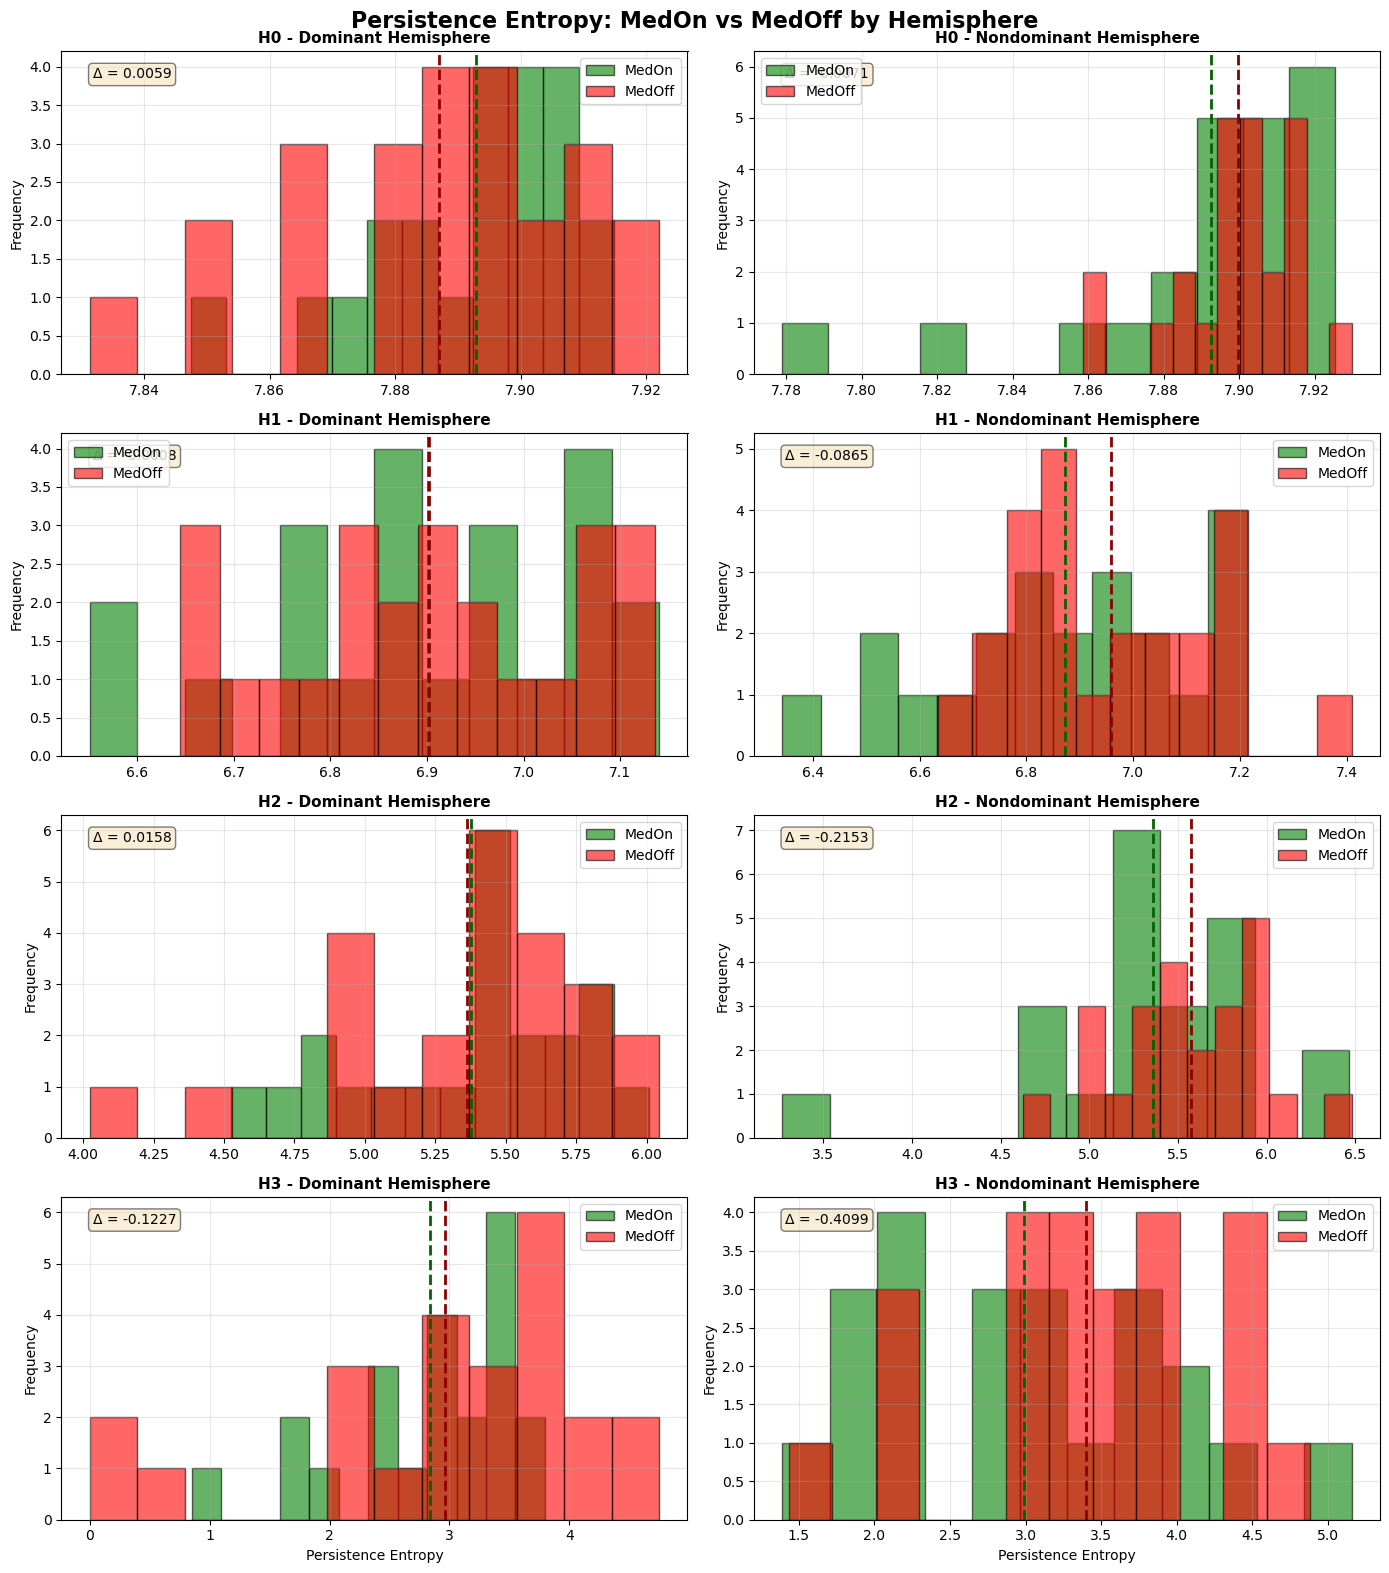


Persistence Entropy: MedOn vs MedOff by Hemisphere

H0:
  DOMINANT Hemisphere:
    MedOn  - Mean: 7.8929, Std: 0.0166
    MedOff - Mean: 7.8869, Std: 0.0227
    Difference: 0.0059
  NONDOMINANT Hemisphere:
    MedOn  - Mean: 7.8924, Std: 0.0344
    MedOff - Mean: 7.8996, Std: 0.0163
    Difference: -0.0071

H1:
  DOMINANT Hemisphere:
    MedOn  - Mean: 6.9008, Std: 0.1628
    MedOff - Mean: 6.9016, Std: 0.1517
    Difference: -0.0008
  NONDOMINANT Hemisphere:
    MedOn  - Mean: 6.8720, Std: 0.2382
    MedOff - Mean: 6.9585, Std: 0.1912
    Difference: -0.0865

H2:
  DOMINANT Hemisphere:
    MedOn  - Mean: 5.3783, Std: 0.4071
    MedOff - Mean: 5.3625, Std: 0.4801
    Difference: 0.0158
  NONDOMINANT Hemisphere:
    MedOn  - Mean: 5.3579, Std: 0.6550
    MedOff - Mean: 5.5732, Std: 0.4267
    Difference: -0.2153

H3:
  DOMINANT Hemisphere:
    MedOn  - Mean: 2.8395, Std: 0.7610
    MedOff - Mean: 2.9622, Std: 1.2328
    Difference: -0.1227
  NONDOMINANT Hemisphere:
    MedOn  - Mean: 2

In [13]:
# Persistence Entropy: MedOn vs MedOff by Hemisphere
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
fig.suptitle('Persistence Entropy: MedOn vs MedOff by Hemisphere', 
             fontsize=16, fontweight='bold')

entropy_features = ['h0_persistence_entropy', 'h1_persistence_entropy', 
                   'h2_persistence_entropy', 'h3_persistence_entropy']
dims = ['H0', 'H1', 'H2', 'H3']

for idx, (feature, dim) in enumerate(zip(entropy_features, dims)):
    # Dominant hemisphere (left column)
    ax_dom = axes[idx, 0]
    medOn_dom = df_dominant[df_dominant['med_state'] == 'medOn'][feature]
    medOff_dom = df_dominant[df_dominant['med_state'] == 'medOff'][feature]
    
    ax_dom.hist(medOn_dom, bins=12, alpha=0.6, color='green', label='MedOn', edgecolor='black')
    ax_dom.hist(medOff_dom, bins=12, alpha=0.6, color='red', label='MedOff', edgecolor='black')
    ax_dom.axvline(medOn_dom.mean(), color='darkgreen', linestyle='--', linewidth=2)
    ax_dom.axvline(medOff_dom.mean(), color='darkred', linestyle='--', linewidth=2)
    
    ax_dom.set_ylabel('Frequency', fontsize=10)
    ax_dom.set_title(f'{dim} - Dominant Hemisphere', fontsize=11, fontweight='bold')
    ax_dom.legend()
    ax_dom.grid(True, alpha=0.3)
    
    diff_dom = medOn_dom.mean() - medOff_dom.mean()
    ax_dom.text(0.05, 0.95, f'Δ = {diff_dom:.4f}', transform=ax_dom.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Nondominant hemisphere (right column)
    ax_nondom = axes[idx, 1]
    medOn_nondom = df_nondominant[df_nondominant['med_state'] == 'medOn'][feature]
    medOff_nondom = df_nondominant[df_nondominant['med_state'] == 'medOff'][feature]
    
    ax_nondom.hist(medOn_nondom, bins=12, alpha=0.6, color='green', label='MedOn', edgecolor='black')
    ax_nondom.hist(medOff_nondom, bins=12, alpha=0.6, color='red', label='MedOff', edgecolor='black')
    ax_nondom.axvline(medOn_nondom.mean(), color='darkgreen', linestyle='--', linewidth=2)
    ax_nondom.axvline(medOff_nondom.mean(), color='darkred', linestyle='--', linewidth=2)
    
    ax_nondom.set_ylabel('Frequency', fontsize=10)
    ax_nondom.set_title(f'{dim} - Nondominant Hemisphere', fontsize=11, fontweight='bold')
    ax_nondom.legend()
    ax_nondom.grid(True, alpha=0.3)
    
    diff_nondom = medOn_nondom.mean() - medOff_nondom.mean()
    ax_nondom.text(0.05, 0.95, f'Δ = {diff_nondom:.4f}', transform=ax_nondom.transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Set x-label only for bottom row
axes[3, 0].set_xlabel('Persistence Entropy', fontsize=10)
axes[3, 1].set_xlabel('Persistence Entropy', fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nPersistence Entropy: MedOn vs MedOff by Hemisphere")
print("="*70)
for feature, dim in zip(entropy_features, dims):
    print(f"\n{dim}:")
    
    # Dominant hemisphere
    medOn_dom = df_dominant[df_dominant['med_state'] == 'medOn'][feature]
    medOff_dom = df_dominant[df_dominant['med_state'] == 'medOff'][feature]
    print(f"  DOMINANT Hemisphere:")
    print(f"    MedOn  - Mean: {medOn_dom.mean():.4f}, Std: {medOn_dom.std():.4f}")
    print(f"    MedOff - Mean: {medOff_dom.mean():.4f}, Std: {medOff_dom.std():.4f}")
    print(f"    Difference: {medOn_dom.mean() - medOff_dom.mean():.4f}")
    
    # Nondominant hemisphere
    medOn_nondom = df_nondominant[df_nondominant['med_state'] == 'medOn'][feature]
    medOff_nondom = df_nondominant[df_nondominant['med_state'] == 'medOff'][feature]
    print(f"  NONDOMINANT Hemisphere:")
    print(f"    MedOn  - Mean: {medOn_nondom.mean():.4f}, Std: {medOn_nondom.std():.4f}")
    print(f"    MedOff - Mean: {medOff_nondom.mean():.4f}, Std: {medOff_nondom.std():.4f}")
    print(f"    Difference: {medOn_nondom.mean() - medOff_nondom.mean():.4f}")

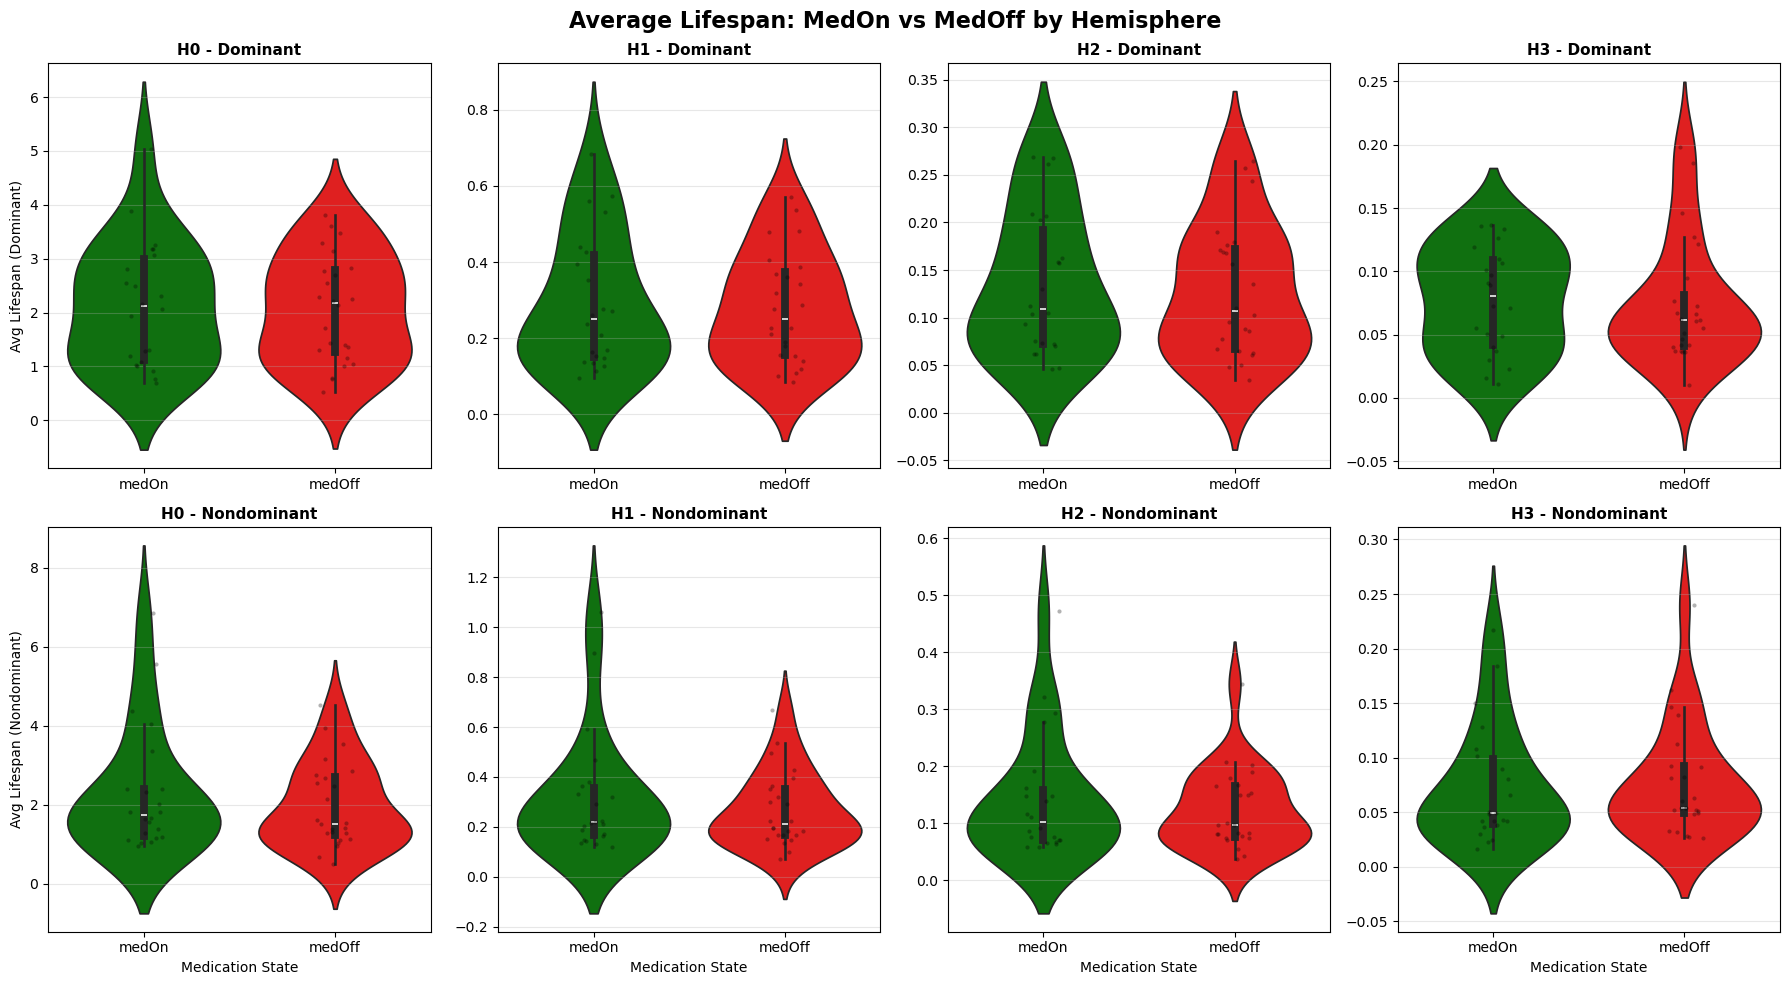


Average Lifespan: MedOn vs MedOff by Hemisphere

H0:
  DOMINANT:
    MedOn  - Mean: 2.1481, Median: 2.1141
    MedOff - Mean: 2.0676, Median: 2.1815
    Difference: 0.0806
  NONDOMINANT:
    MedOn  - Mean: 2.3175, Median: 1.7401
    MedOff - Mean: 1.9723, Median: 1.5210
    Difference: 0.3452

H1:
  DOMINANT:
    MedOn  - Mean: 0.2935, Median: 0.2495
    MedOff - Mean: 0.2795, Median: 0.2506
    Difference: 0.0140
  NONDOMINANT:
    MedOn  - Mean: 0.3178, Median: 0.2182
    MedOff - Mean: 0.2692, Median: 0.2102
    Difference: 0.0486

H2:
  DOMINANT:
    MedOn  - Mean: 0.1340, Median: 0.1089
    MedOff - Mean: 0.1275, Median: 0.1065
    Difference: 0.0065
  NONDOMINANT:
    MedOn  - Mean: 0.1443, Median: 0.1020
    MedOff - Mean: 0.1239, Median: 0.0971
    Difference: 0.0204

H3:
  DOMINANT:
    MedOn  - Mean: 0.0773, Median: 0.0809
    MedOff - Mean: 0.0740, Median: 0.0614
    Difference: 0.0033
  NONDOMINANT:
    MedOn  - Mean: 0.0732, Median: 0.0489
    MedOff - Mean: 0.0764, Media

In [14]:
# Violin plots: Average Lifespan by Hemisphere
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('Average Lifespan: MedOn vs MedOff by Hemisphere', fontsize=16, fontweight='bold')

lifespan_features = ['h0_avg_lifespan', 'h1_avg_lifespan', 'h2_avg_lifespan', 'h3_avg_lifespan']
dims = ['H0', 'H1', 'H2', 'H3']

for idx, (feature, dim) in enumerate(zip(lifespan_features, dims)):
    # Dominant hemisphere (top row)
    ax_dom = axes[0, idx]
    sns.violinplot(data=df_dominant, x='med_state', y=feature, ax=ax_dom, palette=['green', 'red'])
    sns.stripplot(data=df_dominant, x='med_state', y=feature, ax=ax_dom, 
                  color='black', alpha=0.3, size=3)
    ax_dom.set_xlabel('')
    ax_dom.set_ylabel('Avg Lifespan (Dominant)' if idx == 0 else '', fontsize=10)
    ax_dom.set_title(f'{dim} - Dominant', fontsize=11, fontweight='bold')
    ax_dom.grid(True, alpha=0.3, axis='y')
    
    # Nondominant hemisphere (bottom row)
    ax_nondom = axes[1, idx]
    sns.violinplot(data=df_nondominant, x='med_state', y=feature, ax=ax_nondom, palette=['green', 'red'])
    sns.stripplot(data=df_nondominant, x='med_state', y=feature, ax=ax_nondom, 
                  color='black', alpha=0.3, size=3)
    ax_nondom.set_xlabel('Medication State', fontsize=10)
    ax_nondom.set_ylabel('Avg Lifespan (Nondominant)' if idx == 0 else '', fontsize=10)
    ax_nondom.set_title(f'{dim} - Nondominant', fontsize=11, fontweight='bold')
    ax_nondom.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print comparison
print("\nAverage Lifespan: MedOn vs MedOff by Hemisphere")
print("="*70)
for feature, dim in zip(lifespan_features, dims):
    print(f"\n{dim}:")
    
    # Dominant
    medOn_dom = df_dominant[df_dominant['med_state'] == 'medOn'][feature]
    medOff_dom = df_dominant[df_dominant['med_state'] == 'medOff'][feature]
    print(f"  DOMINANT:")
    print(f"    MedOn  - Mean: {medOn_dom.mean():.4f}, Median: {medOn_dom.median():.4f}")
    print(f"    MedOff - Mean: {medOff_dom.mean():.4f}, Median: {medOff_dom.median():.4f}")
    print(f"    Difference: {medOn_dom.mean() - medOff_dom.mean():.4f}")
    
    # Nondominant
    medOn_nondom = df_nondominant[df_nondominant['med_state'] == 'medOn'][feature]
    medOff_nondom = df_nondominant[df_nondominant['med_state'] == 'medOff'][feature]
    print(f"  NONDOMINANT:")
    print(f"    MedOn  - Mean: {medOn_nondom.mean():.4f}, Median: {medOn_nondom.median():.4f}")
    print(f"    MedOff - Mean: {medOff_nondom.mean():.4f}, Median: {medOff_nondom.median():.4f}")
    print(f"    Difference: {medOn_nondom.mean() - medOff_nondom.mean():.4f}")

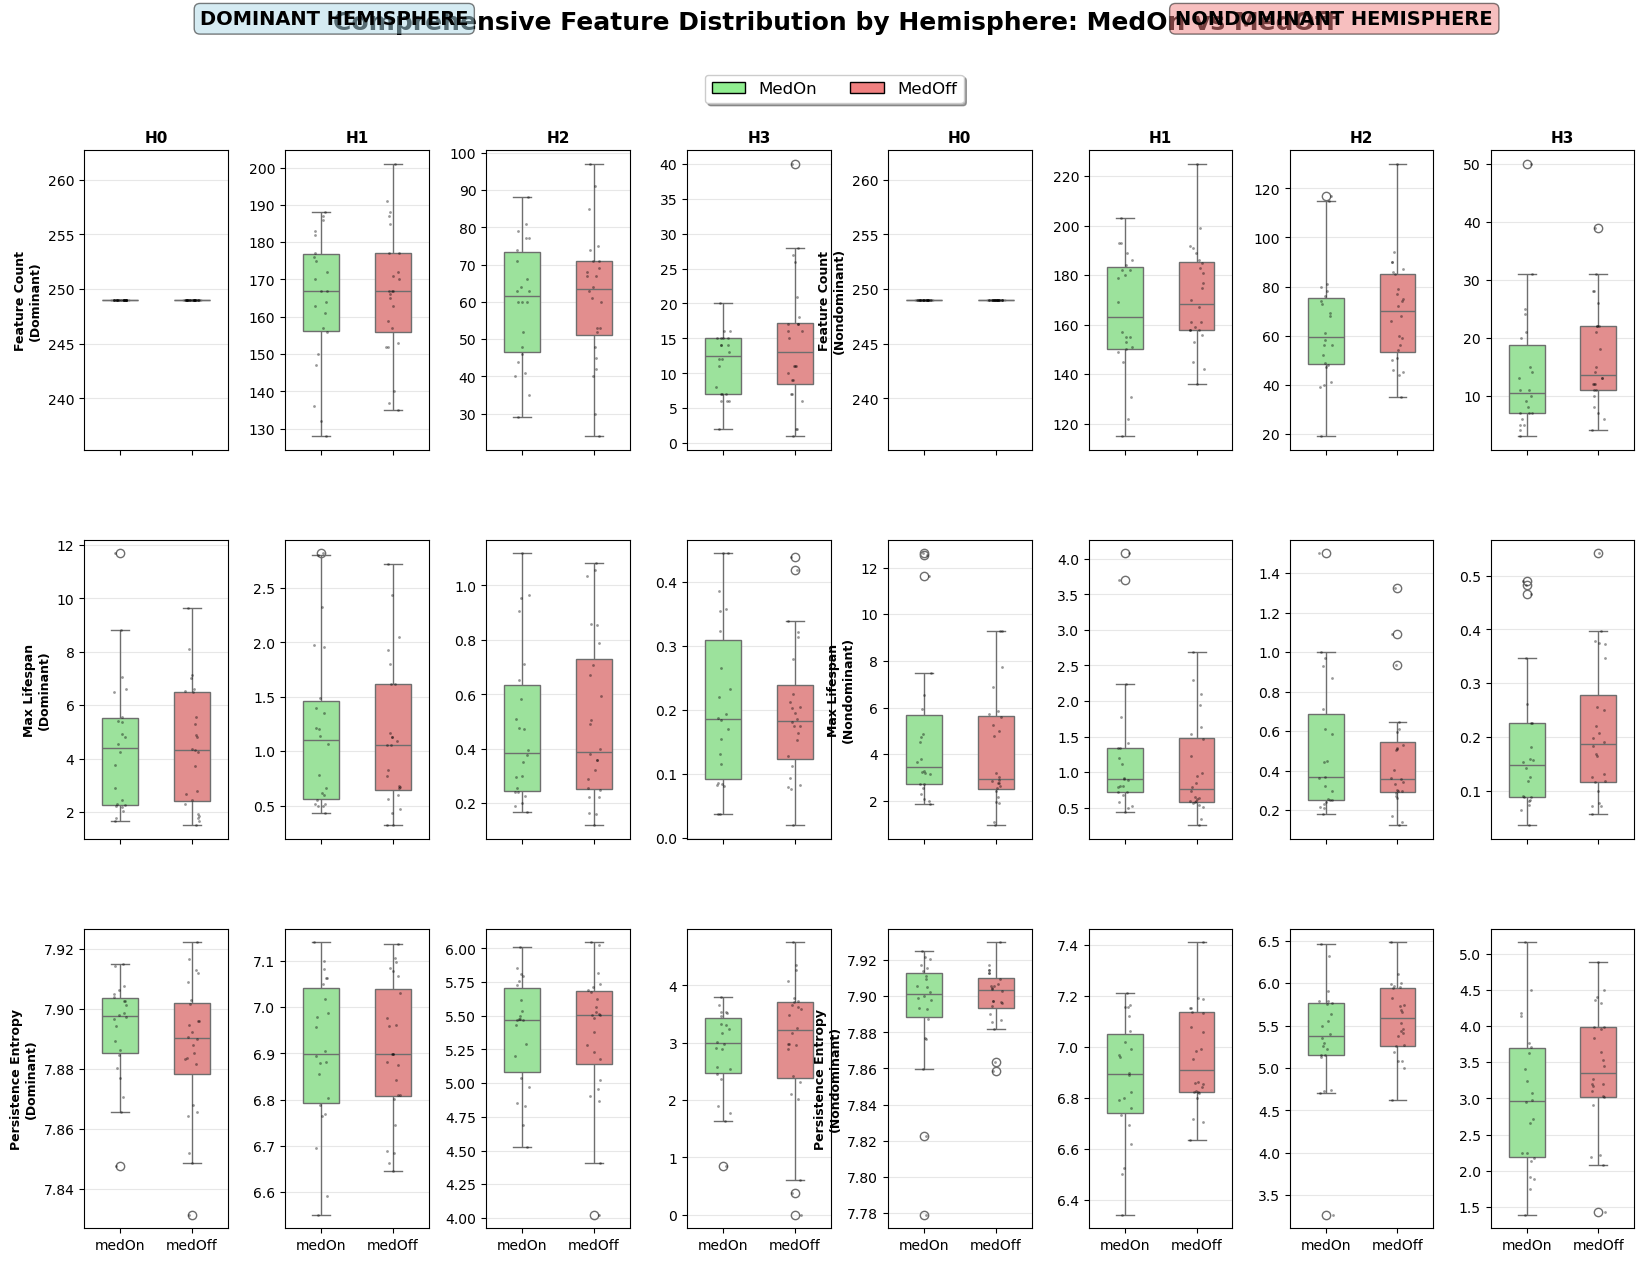


Hemisphere-Specific Box Plot Analysis Complete
Left panel: DOMINANT hemisphere
Right panel: NONDOMINANT hemisphere

Look for:
  - Consistent medOn/medOff differences across both hemispheres (symmetric effect)
  - Differences only in one hemisphere (lateralized effect)
  - Larger separation in dominant vs nondominant (motor-related lateralization)


In [15]:
# Comprehensive box plots by hemisphere - Two large panels
fig = plt.figure(figsize=(20, 14))
fig.suptitle('Comprehensive Feature Distribution by Hemisphere: MedOn vs MedOff', 
             fontsize=18, fontweight='bold')

# Feature groups
feature_groups = {
    'Feature Count': ['h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count'],
    'Max Lifespan': ['h0_max_lifespan', 'h1_max_lifespan', 'h2_max_lifespan', 'h3_max_lifespan'],
    'Persistence Entropy': ['h0_persistence_entropy', 'h1_persistence_entropy', 
                           'h2_persistence_entropy', 'h3_persistence_entropy']
}

dims = ['H0', 'H1', 'H2', 'H3']

# Create gridspec for better layout control
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3, 8, figure=fig, hspace=0.3, wspace=0.4)

# Dominant hemisphere (left 4 columns)
for row_idx, (group_name, features) in enumerate(feature_groups.items()):
    for col_idx, (feature, dim) in enumerate(zip(features, dims)):
        ax = fig.add_subplot(gs[row_idx, col_idx])
        
        # Box plot with points
        sns.boxplot(data=df_dominant, x='med_state', y=feature, ax=ax, 
                   palette=['lightgreen', 'lightcoral'], width=0.5)
        sns.stripplot(data=df_dominant, x='med_state', y=feature, ax=ax,
                     color='black', alpha=0.4, size=2)
        
        # Formatting
        ax.set_xlabel('')
        if col_idx == 0:
            ax.set_ylabel(f'{group_name}\n(Dominant)', fontsize=9, fontweight='bold')
        else:
            ax.set_ylabel('')
        
        # Title only on top row
        if row_idx == 0:
            ax.set_title(f'{dim}', fontsize=11, fontweight='bold')
        else:
            ax.set_title('')
            
        ax.grid(True, alpha=0.3, axis='y')
        
        # Remove x-axis labels except bottom row
        if row_idx < 2:
            ax.set_xticklabels([])

# Nondominant hemisphere (right 4 columns)
for row_idx, (group_name, features) in enumerate(feature_groups.items()):
    for col_idx, (feature, dim) in enumerate(zip(features, dims)):
        ax = fig.add_subplot(gs[row_idx, col_idx + 4])
        
        # Box plot with points
        sns.boxplot(data=df_nondominant, x='med_state', y=feature, ax=ax, 
                   palette=['lightgreen', 'lightcoral'], width=0.5)
        sns.stripplot(data=df_nondominant, x='med_state', y=feature, ax=ax,
                     color='black', alpha=0.4, size=2)
        
        # Formatting
        ax.set_xlabel('')
        if col_idx == 0:
            ax.set_ylabel(f'{group_name}\n(Nondominant)', fontsize=9, fontweight='bold')
        else:
            ax.set_ylabel('')
        
        # Title only on top row
        if row_idx == 0:
            ax.set_title(f'{dim}', fontsize=11, fontweight='bold')
        else:
            ax.set_title('')
            
        ax.grid(True, alpha=0.3, axis='y')
        
        # Remove x-axis labels except bottom row
        if row_idx < 2:
            ax.set_xticklabels([])

# Add hemisphere labels
fig.text(0.25, 0.97, 'DOMINANT HEMISPHERE', ha='center', fontsize=14, fontweight='bold', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
fig.text(0.75, 0.97, 'NONDOMINANT HEMISPHERE', ha='center', fontsize=14, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='MedOn'),
    Patch(facecolor='lightcoral', edgecolor='black', label='MedOff')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.94), 
          ncol=2, fontsize=12, frameon=True, shadow=True)

plt.show()

print("\nHemisphere-Specific Box Plot Analysis Complete")
print("="*70)
print("Left panel: DOMINANT hemisphere")
print("Right panel: NONDOMINANT hemisphere")
print("\nLook for:")
print("  - Consistent medOn/medOff differences across both hemispheres (symmetric effect)")
print("  - Differences only in one hemisphere (lateralized effect)")
print("  - Larger separation in dominant vs nondominant (motor-related lateralization)")

### Normality Assessment by Hemisphere

Since we've split the data by hemisphere (46 observations each), we need to assess normality separately for each subset. This is important because:
- Sample size is halved (could affect distributional properties)
- Hemispheres may have inherently different distributions
- Determines appropriate statistical tests for hemisphere-specific analyses

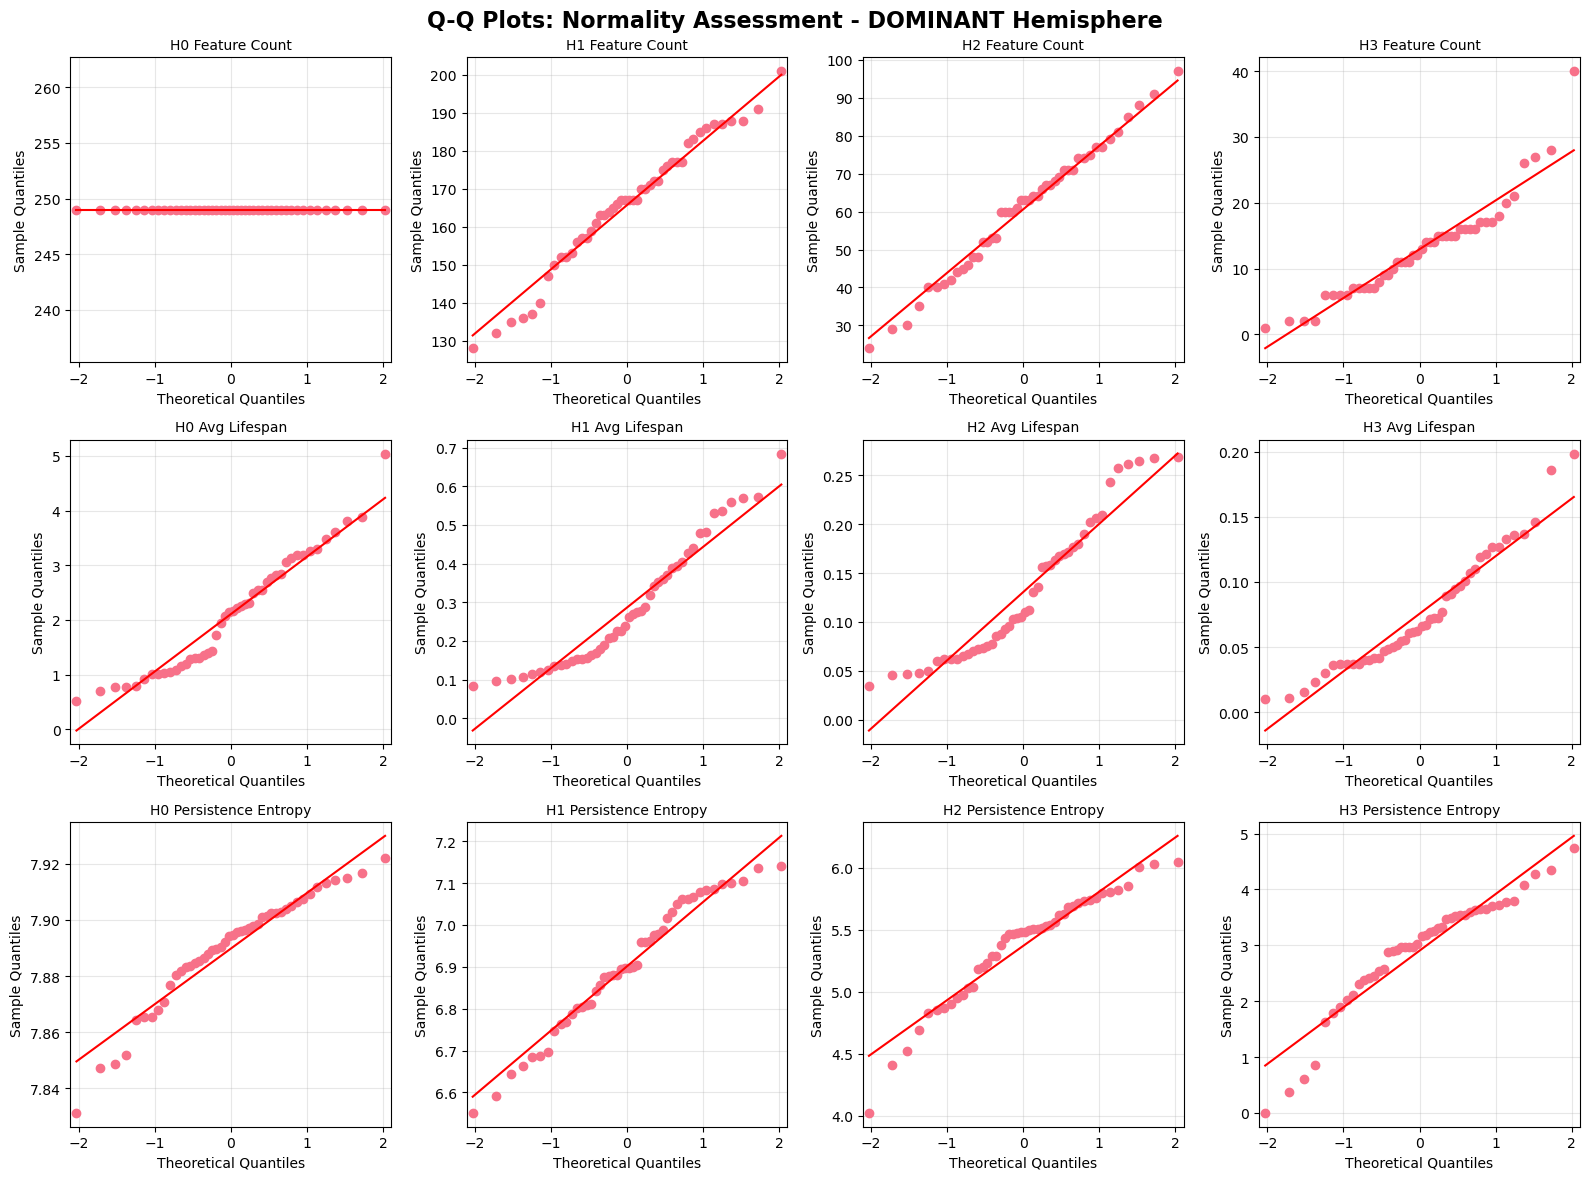

In [16]:
# Q-Q Plots for Dominant Hemisphere
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Q-Q Plots: Normality Assessment - DOMINANT Hemisphere', 
             fontsize=16, fontweight='bold')

test_features = [
    'h0_feature_count', 'h1_feature_count', 'h2_feature_count', 'h3_feature_count',
    'h0_avg_lifespan', 'h1_avg_lifespan', 'h2_avg_lifespan', 'h3_avg_lifespan',
    'h0_persistence_entropy', 'h1_persistence_entropy', 'h2_persistence_entropy', 'h3_persistence_entropy'
]

for idx, feature in enumerate(test_features):
    row, col = idx // 4, idx % 4
    ax = axes[row, col]
    
    # Create Q-Q plot for dominant hemisphere
    sm.qqplot(df_dominant[feature].dropna(), line='s', ax=ax)
    ax.set_title(feature.replace('_', ' ').title(), fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

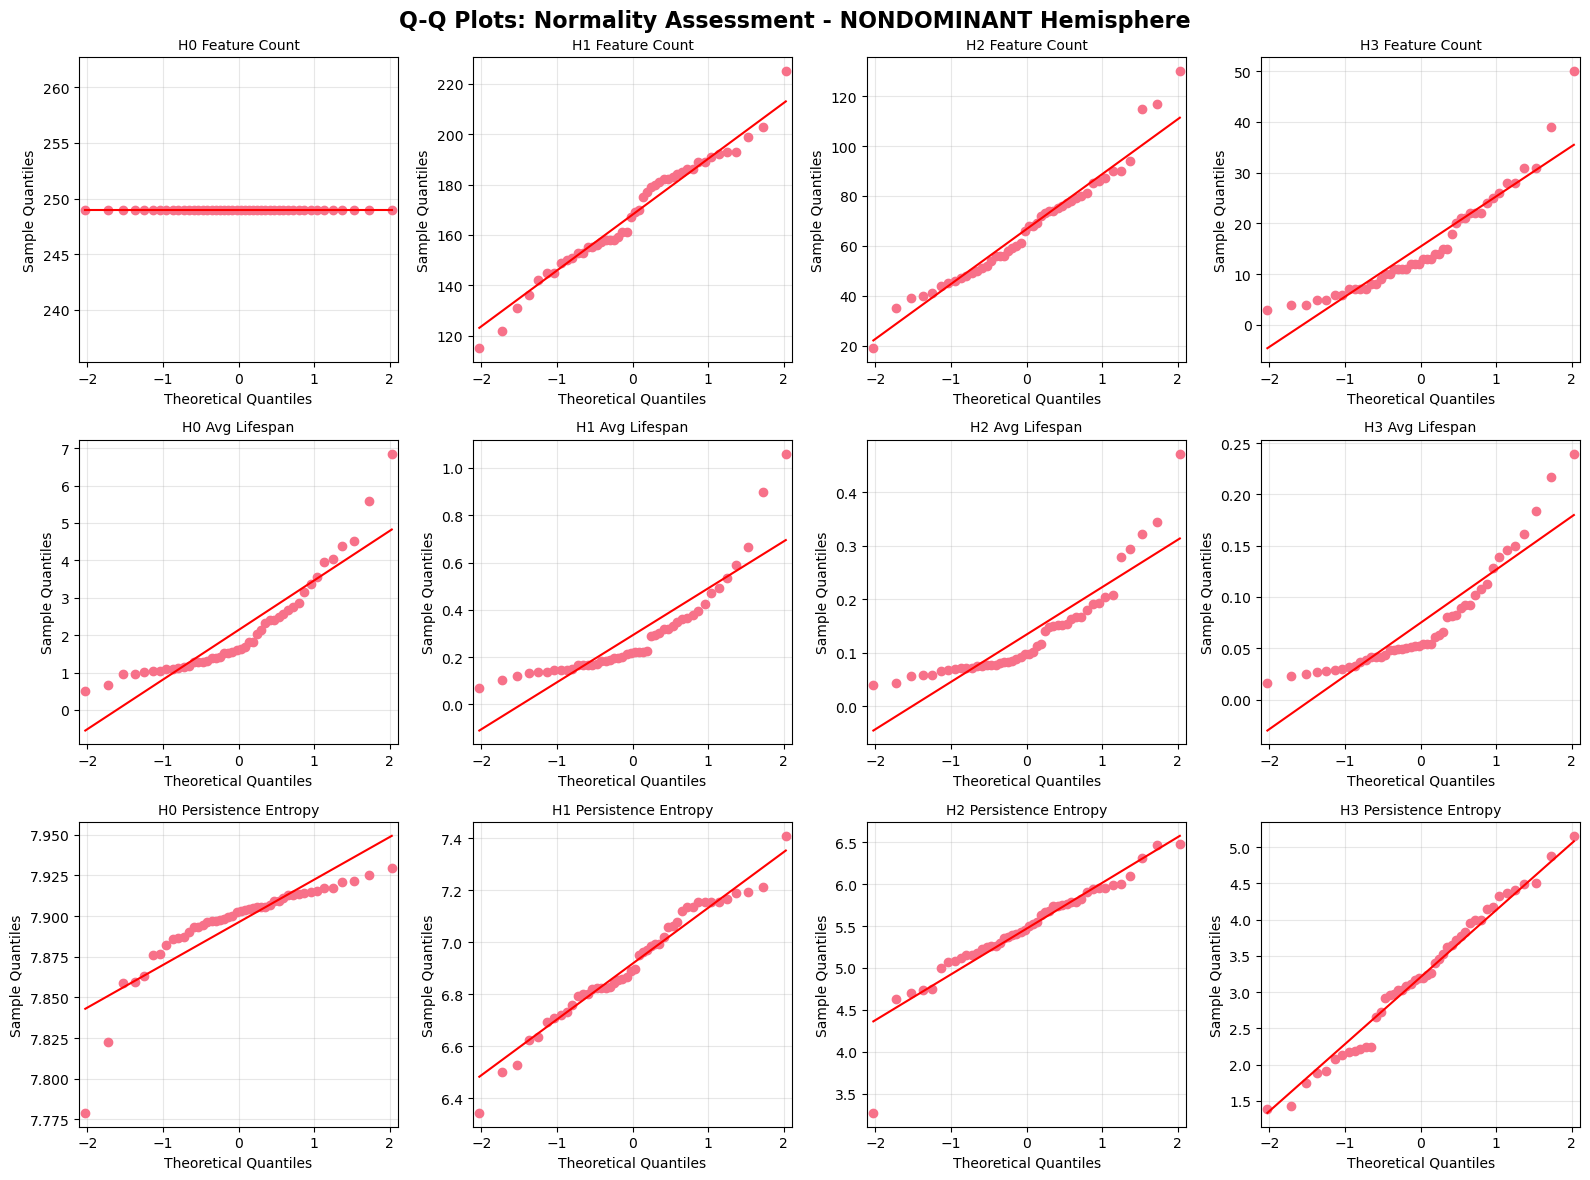

In [17]:
# Q-Q Plots for Nondominant Hemisphere
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Q-Q Plots: Normality Assessment - NONDOMINANT Hemisphere', 
             fontsize=16, fontweight='bold')

for idx, feature in enumerate(test_features):
    row, col = idx // 4, idx % 4
    ax = axes[row, col]
    
    # Create Q-Q plot for nondominant hemisphere
    sm.qqplot(df_nondominant[feature].dropna(), line='s', ax=ax)
    ax.set_title(feature.replace('_', ' ').title(), fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Shapiro-Wilk Normality Tests by Hemisphere - MedOn, MedOff, and Differences
print("Shapiro-Wilk Normality Tests by Hemisphere: MedOn vs MedOff vs Differences")
print("="*90)
print("Null hypothesis: Data is normally distributed")
print("If p-value < 0.05, reject null hypothesis (data is NOT normal)")
print("="*90)
print("\nTesting each hemisphere separately with medOn, medOff, and paired differences.")
print("For hemisphere-specific paired t-tests, the DIFFERENCES must be normally distributed.")
print("="*90)

hemisphere_normality_results = []

# Separate data by hemisphere and medication state
df_dom_medOn = df_dominant[df_dominant['med_state'] == 'medOn']
df_dom_medOff = df_dominant[df_dominant['med_state'] == 'medOff']
df_nondom_medOn = df_nondominant[df_nondominant['med_state'] == 'medOn']
df_nondom_medOff = df_nondominant[df_nondominant['med_state'] == 'medOff']

for feature in test_features:
    # ===== DOMINANT HEMISPHERE =====
    # Test 1: Dominant MedOn
    dom_medOn_data = df_dom_medOn[feature].dropna()
    stat_dom_on, p_dom_on = shapiro(dom_medOn_data)
    hemisphere_normality_results.append({
        'Feature': feature,
        'Hemisphere': 'Dominant',
        'Test Type': 'MedOn',
        'N': len(dom_medOn_data),
        'Statistic': stat_dom_on,
        'p-value': p_dom_on,
        'Normal (α=0.05)': "Yes" if p_dom_on > 0.05 else "No"
    })
    
    # Test 2: Dominant MedOff
    dom_medOff_data = df_dom_medOff[feature].dropna()
    stat_dom_off, p_dom_off = shapiro(dom_medOff_data)
    hemisphere_normality_results.append({
        'Feature': feature,
        'Hemisphere': 'Dominant',
        'Test Type': 'MedOff',
        'N': len(dom_medOff_data),
        'Statistic': stat_dom_off,
        'p-value': p_dom_off,
        'Normal (α=0.05)': "Yes" if p_dom_off > 0.05 else "No"
    })
    
    # Test 3: Dominant Differences
    dom_medOn_vals = df_dom_medOn.groupby('patient_id')[feature].mean()
    dom_medOff_vals = df_dom_medOff.groupby('patient_id')[feature].mean()
    dom_differences = dom_medOn_vals - dom_medOff_vals
    
    stat_dom_diff, p_dom_diff = shapiro(dom_differences.dropna())
    hemisphere_normality_results.append({
        'Feature': feature,
        'Hemisphere': 'Dominant',
        'Test Type': 'Difference',
        'N': len(dom_differences.dropna()),
        'Statistic': stat_dom_diff,
        'p-value': p_dom_diff,
        'Normal (α=0.05)': "Yes" if p_dom_diff > 0.05 else "No"
    })
    
    # ===== NONDOMINANT HEMISPHERE =====
    # Test 4: Nondominant MedOn
    nondom_medOn_data = df_nondom_medOn[feature].dropna()
    stat_nondom_on, p_nondom_on = shapiro(nondom_medOn_data)
    hemisphere_normality_results.append({
        'Feature': feature,
        'Hemisphere': 'Nondominant',
        'Test Type': 'MedOn',
        'N': len(nondom_medOn_data),
        'Statistic': stat_nondom_on,
        'p-value': p_nondom_on,
        'Normal (α=0.05)': "Yes" if p_nondom_on > 0.05 else "No"
    })
    
    # Test 5: Nondominant MedOff
    nondom_medOff_data = df_nondom_medOff[feature].dropna()
    stat_nondom_off, p_nondom_off = shapiro(nondom_medOff_data)
    hemisphere_normality_results.append({
        'Feature': feature,
        'Hemisphere': 'Nondominant',
        'Test Type': 'MedOff',
        'N': len(nondom_medOff_data),
        'Statistic': stat_nondom_off,
        'p-value': p_nondom_off,
        'Normal (α=0.05)': "Yes" if p_nondom_off > 0.05 else "No"
    })
    
    # Test 6: Nondominant Differences
    nondom_medOn_vals = df_nondom_medOn.groupby('patient_id')[feature].mean()
    nondom_medOff_vals = df_nondom_medOff.groupby('patient_id')[feature].mean()
    nondom_differences = nondom_medOn_vals - nondom_medOff_vals
    
    stat_nondom_diff, p_nondom_diff = shapiro(nondom_differences.dropna())
    hemisphere_normality_results.append({
        'Feature': feature,
        'Hemisphere': 'Nondominant',
        'Test Type': 'Difference',
        'N': len(nondom_differences.dropna()),
        'Statistic': stat_nondom_diff,
        'p-value': p_nondom_diff,
        'Normal (α=0.05)': "Yes" if p_nondom_diff > 0.05 else "No"
    })

# Create DataFrame
hemisphere_normality_df = pd.DataFrame(hemisphere_normality_results)

# Display results grouped by feature
print("\n")
for feature in test_features:
    feature_results = hemisphere_normality_df[hemisphere_normality_df['Feature'] == feature]
    print(f"\n{feature}:")
    print(f"{'Hemisphere':<15} {'Test Type':<12} {'N':<5} {'Statistic':<12} {'p-value':<12} {'Normal?':<10}")
    print("-"*70)
    for _, row in feature_results.iterrows():
        print(f"{row['Hemisphere']:<15} {row['Test Type']:<12} {row['N']:<5} "
              f"{row['Statistic']:<12.4f} {row['p-value']:<12.4f} {row['Normal (α=0.05)']:<10}")

# TEST SELECTION RECOMMENDATIONS
print("\n" + "="*90)
print("TEST SELECTION RECOMMENDATIONS (Based on Difference Normality)")
print("="*90)

# Get difference normality for each hemisphere
diff_results = hemisphere_normality_df[hemisphere_normality_df['Test Type'] == 'Difference'].copy()

print("\n--- DOMINANT HEMISPHERE ---")
dom_diff = diff_results[diff_results['Hemisphere'] == 'Dominant']
dom_normal = dom_diff[dom_diff['Normal (α=0.05)'] == 'Yes']['Feature'].tolist()
dom_nonnormal = dom_diff[dom_diff['Normal (α=0.05)'] == 'No']['Feature'].tolist()

print(f"\n✓ Use PAIRED T-TEST for {len(dom_normal)} features (differences are normal):")
for feat in dom_normal:
    print(f"   - {feat}")
print(f"\n✗ Use WILCOXON TEST for {len(dom_nonnormal)} features (differences are NOT normal):")
for feat in dom_nonnormal:
    print(f"   - {feat}")

print("\n--- NONDOMINANT HEMISPHERE ---")
nondom_diff = diff_results[diff_results['Hemisphere'] == 'Nondominant']
nondom_normal = nondom_diff[nondom_diff['Normal (α=0.05)'] == 'Yes']['Feature'].tolist()
nondom_nonnormal = nondom_diff[nondom_diff['Normal (α=0.05)'] == 'No']['Feature'].tolist()

print(f"\n✓ Use PAIRED T-TEST for {len(nondom_normal)} features (differences are normal):")
for feat in nondom_normal:
    print(f"   - {feat}")
print(f"\n✗ Use WILCOXON TEST for {len(nondom_nonnormal)} features (differences are NOT normal):")
for feat in nondom_nonnormal:
    print(f"   - {feat}")

# COMPARISON: Features with different test recommendations between hemispheres
print("\n" + "="*90)
print("LATERALIZATION IN NORMALITY")
print("="*90)

different_recommendations = []
for feat in test_features:
    dom_test = 't-test' if feat in dom_normal else 'Wilcoxon'
    nondom_test = 't-test' if feat in nondom_normal else 'Wilcoxon'
    if dom_test != nondom_test:
        different_recommendations.append({
            'Feature': feat,
            'Dominant': dom_test,
            'Nondominant': nondom_test
        })

if len(different_recommendations) > 0:
    print(f"\n{len(different_recommendations)} features require DIFFERENT tests for each hemisphere:")
    for rec in different_recommendations:
        print(f"  - {rec['Feature']}: Dominant={rec['Dominant']}, Nondominant={rec['Nondominant']}")
    print("\n→ This suggests hemisphere-specific distributional differences")
else:
    print("\nAll features use the same test type across both hemispheres.")

# SUMMARY
print("\n" + "="*90)
print("SUMMARY")
print("="*90)
medOn_dom = hemisphere_normality_df[(hemisphere_normality_df['Hemisphere'] == 'Dominant') & 
                                     (hemisphere_normality_df['Test Type'] == 'MedOn') & 
                                     (hemisphere_normality_df['Normal (α=0.05)'] == 'Yes')]
medOff_dom = hemisphere_normality_df[(hemisphere_normality_df['Hemisphere'] == 'Dominant') & 
                                      (hemisphere_normality_df['Test Type'] == 'MedOff') & 
                                      (hemisphere_normality_df['Normal (α=0.05)'] == 'Yes')]
medOn_nondom = hemisphere_normality_df[(hemisphere_normality_df['Hemisphere'] == 'Nondominant') & 
                                        (hemisphere_normality_df['Test Type'] == 'MedOn') & 
                                        (hemisphere_normality_df['Normal (α=0.05)'] == 'Yes')]
medOff_nondom = hemisphere_normality_df[(hemisphere_normality_df['Hemisphere'] == 'Nondominant') & 
                                         (hemisphere_normality_df['Test Type'] == 'MedOff') & 
                                         (hemisphere_normality_df['Normal (α=0.05)'] == 'Yes')]

print(f"\nDominant hemisphere:")
print(f"  - MedOn normal: {len(medOn_dom)}/{len(test_features)}")
print(f"  - MedOff normal: {len(medOff_dom)}/{len(test_features)}")
print(f"  - Differences normal: {len(dom_normal)}/{len(test_features)}")

print(f"\nNondominant hemisphere:")
print(f"  - MedOn normal: {len(medOn_nondom)}/{len(test_features)}")
print(f"  - MedOff normal: {len(medOff_nondom)}/{len(test_features)}")
print(f"  - Differences normal: {len(nondom_normal)}/{len(test_features)}")

Shapiro-Wilk Normality Tests by Hemisphere: MedOn vs MedOff vs Differences
Null hypothesis: Data is normally distributed
If p-value < 0.05, reject null hypothesis (data is NOT normal)

Testing each hemisphere separately with medOn, medOff, and paired differences.
For hemisphere-specific paired t-tests, the DIFFERENCES must be normally distributed.



h0_feature_count:
Hemisphere      Test Type    N     Statistic    p-value      Normal?   
----------------------------------------------------------------------
Dominant        MedOn        22    1.0000       1.0000       Yes       
Dominant        MedOff       24    1.0000       1.0000       Yes       
Dominant        Difference   9     1.0000       1.0000       Yes       
Nondominant     MedOn        22    1.0000       1.0000       Yes       
Nondominant     MedOff       24    1.0000       1.0000       Yes       
Nondominant     Difference   9     1.0000       1.0000       Yes       

h1_feature_count:
Hemisphere      Test Type    N     

### Hemisphere-Specific Normality Assessment Summary

The normality tests reveal important considerations for hemisphere-specific analyses:

#### Key Findings

1. **Sample Size Effect**: With only 46 observations per hemisphere (vs 92 combined), normality assumptions may be more easily violated

2. **Hemisphere Differences**: Features that are normal in one hemisphere but not the other suggest:
   - Inherent distributional differences between hemispheres
   - Potential biological asymmetry
   - Need for hemisphere-specific statistical approaches

3. **Statistical Test Selection**:
   - **If both hemispheres normal**: Can use parametric tests (paired t-tests) for each hemisphere
   - **If one or both non-normal**: Should use non-parametric tests (Wilcoxon) for that hemisphere
   - **For hemisphere comparisons**: May need mixed-effects models or repeated-measures ANOVA
   - H0-H1-H2 feature count, H1 Persistence entropy are normally distributed for both hemispheres,
    H3 persistence entropy is normally distributed only for non-dominant hemisphere

#### Implications for Analysis

- **Symmetric normality**: Features normal in both hemispheres can be analyzed with standard parametric approaches
- **Asymmetric normality**: Features with different distributions between hemispheres are particularly interesting
  - May indicate functional specialization
  - Could reveal lateralized effects of Parkinson's disease or medication
  - Require careful choice of statistical methods

#### Recommendations

Based on normality results:
- Use **Wilcoxon signed-rank test** for non-normal features when doing hemisphere-specific paired comparisons
- Consider **permutation tests** for features with inconsistent normality across hemispheres
- Document which tests were used for which features in subsequent analyses

### Hemisphere-Specific Analysis Summary

The hemisphere-specific visualizations reveal:

#### Key Observations

**Dominant Hemisphere (Motor Control Side):**
- Controls the arm performing the hold task (contralateral motor control)
- Check if medOn/medOff effects are stronger here due to motor symptom improvement

**Nondominant Hemisphere:**
- Contralateral to the resting/non-active arm
- May show different medication response patterns

#### Lateralization Patterns to Look For

1. **Symmetric Effects**: MedOn vs MedOff differences are similar in both hemispheres
   - Suggests global medication effects on brain activity

2. **Lateralized Effects**: Differences appear only in dominant OR nondominant hemisphere
   - Suggests medication specifically affects motor-related neural activity
   - Could indicate hemisphere specialization in Parkinson's disease

3. **Differential Magnitude**: Both hemispheres show effects, but one is stronger
   - Partial lateralization of medication response

#### Visual Inspection Results

From the plots above:
- **Feature counts**: Compare H1-H3 counts between hemispheres
- **Persistence entropy**: Note any hemisphere-specific patterns in H1/H2 (oscillatory features)
- **Lifespan statistics**: Check if medication effects on temporal persistence differ by hemisphere

#### Next Steps for Hemisphere Analysis

1. Quantify lateralization with statistical tests
2. Test for interactions: hemisphere × medication state
3. Examine if dominant hemisphere shows larger effect sizes
4. Consider motor symptom lateralization in Parkinson's disease

**Note**: Formal statistical testing (mixed-effects models with hemisphere as a factor) will determine significance of these patterns.

In [19]:
# Quantitative comparison table: Hemisphere × Medication State
# Focus on key features that might show lateralization

key_comparison_features = {
    'H0 Feature Count': 'h0_feature_count',
    'H1 Feature Count': 'h1_feature_count',
    'H2 Feature Count': 'h2_feature_count',
    'H3 Feature Count': 'h3_feature_count',
    'H0 Persistence Entropy': 'h0_persistence_entropy',
    'H1 Persistence Entropy': 'h1_persistence_entropy',
    'H2 Persistence Entropy': 'h2_persistence_entropy',
    'H3 Persistence Entropy': 'h3_persistence_entropy',
    'H1 Avg Lifespan': 'h1_avg_lifespan',
    'H2 Avg Lifespan': 'h2_avg_lifespan'
}

comparison_data = []

for feature_name, feature_col in key_comparison_features.items():
    # Dominant hemisphere
    dom_medOn = df_dominant[df_dominant['med_state'] == 'medOn'][feature_col].mean()
    dom_medOff = df_dominant[df_dominant['med_state'] == 'medOff'][feature_col].mean()
    dom_diff = dom_medOn - dom_medOff

    # Nondominant hemisphere
    nondom_medOn = df_nondominant[df_nondominant['med_state'] == 'medOn'][feature_col].mean()
    nondom_medOff = df_nondominant[df_nondominant['med_state'] == 'medOff'][feature_col].mean()
    nondom_diff = nondom_medOn - nondom_medOff

    # Lateralization index: difference between hemisphere differences
    # Positive: dominant shows larger medOn-medOff difference
    # Negative: nondominant shows larger medOn-medOff difference
    lateralization_index = dom_diff - nondom_diff

    comparison_data.append({
        'Feature': feature_name,
        'Dom MedOn': dom_medOn,
        'Dom MedOff': dom_medOff,
        'Dom Δ': dom_diff,
        'NonDom MedOn': nondom_medOn,
        'NonDom MedOff': nondom_medOff,
        'NonDom Δ': nondom_diff,
        'Lateralization Index': lateralization_index
    })

comparison_df = pd.DataFrame(comparison_data)

print("Quantitative Hemisphere × Medication State Comparison")
print("="*70)
print("\nLegend:")
print("  Dom Δ = Dominant: MedOn - MedOff")
print("  NonDom Δ = Nondominant: MedOn - MedOff")
print("  Lateralization Index = (Dom Δ) - (NonDom Δ)")
print("    Positive: Dominant hemisphere shows larger medication effect")
print("    Negative: Nondominant hemisphere shows larger medication effect")
print("    Near zero: Symmetric effect across hemispheres")
print("="*70)
print("\n")
display(comparison_df)

# Highlight features with strongest lateralization
print("\n" + "="*70)
print("Features with Strongest Lateralization (|Index| > threshold)")
print("="*70)

# Sort by absolute lateralization index
comparison_df['Abs_Lat_Index'] = comparison_df['Lateralization Index'].abs()
lateralized_features = comparison_df.nlargest(5, 'Abs_Lat_Index')[['Feature', 'Dom Δ', 'NonDom Δ', 'Lateralization Index']]

print("\nTop 5 Most Lateralized Features:")
display(lateralized_features)

print("\nInterpretation:")
print("  - Features with large |Lateralization Index| show hemisphere-specific medication effects")
print("  - These may be the most interesting for understanding lateralized Parkinson's pathology")

Quantitative Hemisphere × Medication State Comparison

Legend:
  Dom Δ = Dominant: MedOn - MedOff
  NonDom Δ = Nondominant: MedOn - MedOff
  Lateralization Index = (Dom Δ) - (NonDom Δ)
    Positive: Dominant hemisphere shows larger medication effect
    Negative: Nondominant hemisphere shows larger medication effect
    Near zero: Symmetric effect across hemispheres




,Feature,Dom MedOn,Dom MedOff,Dom Δ,NonDom MedOn,NonDom MedOff,NonDom Δ,Lateralization Index
0,H0 Feature Count,249.000,249.000,0.000e+00,249.000,249.000,0.000,0.000
1,H1 Feature Count,164.727,166.625,-1.898e+00,164.682,171.125,-6.443,4.545
2,H2 Feature Count,59.909,61.250,-1.341e+00,63.500,69.708,-6.208,4.867
3,H3 Feature Count,11.409,14.333,-2.924e+00,13.909,16.875,-2.966,0.042
4,H0 Persistence Entropy,7.893,7.887,5.940e-03,7.892,7.900,-0.007,0.013
5,H1 Persistence Entropy,6.901,6.902,-8.286e-04,6.872,6.958,-0.086,0.086
6,H2 Persistence Entropy,5.378,5.362,1.582e-02,5.358,5.573,-0.215,0.231
7,H3 Persistence Entropy,2.840,2.962,-1.227e-01,2.992,3.402,-0.410,0.287
8,H1 Avg Lifespan,0.294,0.280,1.404e-02,0.318,0.269,0.049,-0.035
9,H2 Avg Lifespan,0.134,0.127,6.504e-03,0.144,0.124,0.020,-0.014



Features with Strongest Lateralization (|Index| > threshold)

Top 5 Most Lateralized Features:


,Feature,Dom Δ,NonDom Δ,Lateralization Index
2,H2 Feature Count,-1.341e+00,-6.208,4.867
1,H1 Feature Count,-1.898e+00,-6.443,4.545
7,H3 Persistence Entropy,-1.227e-01,-0.410,0.287
6,H2 Persistence Entropy,1.582e-02,-0.215,0.231
5,H1 Persistence Entropy,-8.286e-04,-0.086,0.086



Interpretation:
  - Features with large |Lateralization Index| show hemisphere-specific medication effects
  - These may be the most interesting for understanding lateralized Parkinson's pathology


---

# Statistical Testing: MedOn vs MedOff Comparison (Pooled Data)

## Purpose

Now that we've assessed normality and visualized distributions, we proceed to **formal statistical hypothesis testing** to determine which topological features significantly differ between medication states.

### Research Question

**Do topological features of brain activity significantly change when Parkinson's patients are on medication (medOn) compared to off medication (medOff)?**

### Approach

#### 1. **Paired Comparison Design**
- **9 paired patients** with both medOn and medOff data
- Each patient serves as their own control
- **Within-patient comparison** controls for inter-individual variability
- Maximizes statistical power despite small sample size

#### 2. **Test Selection Based on Normality**

From our normality assessment (Shapiro-Wilk test, pooled data):

**Normally Distributed Features (4 features) → Paired T-Test:**
- `h0_feature_count` (p=1.000)
- `h1_feature_count` (p=0.681)
- `h2_feature_count` (p=0.138)
- `h1_persistence_entropy` (p=0.431)

**Non-Normally Distributed Features (8 features) → Wilcoxon Signed-Rank Test:**
- `h0_avg_lifespan`, `h1_avg_lifespan`, `h2_avg_lifespan`, `h3_avg_lifespan`
- `h3_feature_count`
- `h0_persistence_entropy`, `h2_persistence_entropy`, `h3_persistence_entropy`

#### 3. **Multiple Comparison Correction**

Testing 12 features creates a **multiple comparison problem**:
- **Without correction**: ~76% chance of at least 1 false positive
- **With FDR correction**: Control false discovery rate at 5%

We'll use the **Benjamini-Hochberg FDR** (False Discovery Rate) method:
- Less conservative than Bonferroni
- Appropriate for exploratory analysis
- Balances sensitivity and specificity

### What We'll Learn

For each feature:
1. **Statistical significance**: Is the difference real or due to chance?
2. **Effect size**: How large is the medication effect?
3. **Direction**: Does medication increase or decrease the feature?
4. **Robustness**: Does significance survive multiple comparison correction?

### Expected Outcomes

- Identify which topological features are **sensitive to dopaminergic medication**
- Determine whether medication affects:
  - **Connectivity** (H0: connected components)
  - **Oscillatory patterns** (H1: loops/cycles)
  - **Higher-order structure** (H2, H3: voids)
- Understand **which homology dimensions** are most discriminative
- Provide foundation for understanding how medication alters brain topology

---

In [34]:
# Import additional statistical functions
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

print("="*80)
print("STATISTICAL TESTING: MedOn vs MedOff (Pooled Data, Paired Comparisons)")
print("="*80)

# Automatically extract normal vs non-normal features from Cell 8 normality results
# Based on paired DIFFERENCE normality (the correct criterion for paired t-tests)
diff_results = normality_df[normality_df['Test Type'] == 'Difference'].copy()

normal_features = diff_results[diff_results['Normal (α=0.05)'] == 'Yes']['Feature'].tolist()
nonnormal_features = diff_results[diff_results['Normal (α=0.05)'] == 'No']['Feature'].tolist()

print("\n" + "="*80)
print("TEST SELECTION (based on paired difference normality from Cell 8)")
print("="*80)
print(f"\nNormal features (using paired t-test): {len(normal_features)}")
for feat in normal_features:
    print(f"  ✓ {feat}")
    
print(f"\nNon-normal features (using Wilcoxon signed-rank test): {len(nonnormal_features)}")
for feat in nonnormal_features:
    print(f"  ✗ {feat}")

print(f"\nTotal tests: {len(normal_features) + len(nonnormal_features)}")
print(f"Paired patients: {df_paired['patient_id'].nunique()}")

# Storage for all results
all_results = []

print("\n" + "="*80)
print("PAIRED T-TESTS (Normally Distributed Differences)")
print("="*80)

if len(normal_features) > 0:
    for feature in normal_features:
        print(f"\n[{feature}]")
        result = paired_ttest(df_paired, feature, verbose=True)
        result['test_type'] = 'Paired t-test'
        all_results.append(result)
        print("-" * 70)
else:
    print("\nNo features have normally distributed differences.")

print("\n" + "="*80)
print("WILCOXON SIGNED-RANK TESTS (Non-Normally Distributed Differences)")
print("="*80)

if len(nonnormal_features) > 0:
    for feature in nonnormal_features:
        print(f"\n[{feature}]")
        
        # Use wilcoxon_test from analysis_utils if available, else compute manually
        try:
            from analysis_utils import wilcoxon_test
            result = wilcoxon_test(df_paired, feature, verbose=True)
        except (ImportError, AttributeError):
            # Manual computation if function not available
            print("  Using manual Wilcoxon test computation...")
            
            # Get medOn and medOff values for each patient
            # Average across hemispheres and conditions for each patient
            medOn_vals = df_paired[df_paired['med_state'] == 'medOn'].groupby('patient_id')[feature].mean()
            medOff_vals = df_paired[df_paired['med_state'] == 'medOff'].groupby('patient_id')[feature].mean()
            
            # Ensure same patient ordering
            medOn_vals = medOn_vals.sort_index()
            medOff_vals = medOff_vals.sort_index()
            
            # Wilcoxon test
            statistic, p_value = wilcoxon(medOn_vals, medOff_vals)
            
            # Compute effect size (rank-biserial correlation)
            n = len(medOn_vals)
            r = 1 - (2*statistic) / (n*(n+1))
            
            result = {
                'feature': feature,
                'medOn_mean': medOn_vals.mean(),
                'medOff_mean': medOff_vals.mean(),
                'medOn_median': medOn_vals.median(),
                'medOff_median': medOff_vals.median(),
                'difference_mean': medOn_vals.mean() - medOff_vals.mean(),
                'difference_median': medOn_vals.median() - medOff_vals.median(),
                'statistic': statistic,
                'p_value': p_value,
                'effect_size': r,
                'n_pairs': n
            }
            
            print(f"  MedOn   - Mean: {result['medOn_mean']:.4f}, Median: {result['medOn_median']:.4f}")
            print(f"  MedOff  - Mean: {result['medOff_mean']:.4f}, Median: {result['medOff_median']:.4f}")
            print(f"  Difference (mean): {result['difference_mean']:.4f}")
            print(f"  Difference (median): {result['difference_median']:.4f}")
            print(f"  Wilcoxon statistic: {statistic:.2f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  Effect size (r): {r:.3f}")
            
            if p_value < 0.05:
                direction = "increased" if result['difference_median'] > 0 else "decreased"
                print(f"  → SIGNIFICANT (uncorrected): {feature} {direction} with medication")
            else:
                print(f"  → Not significant (uncorrected)")
        
        result['test_type'] = 'Wilcoxon signed-rank'
        all_results.append(result)
        print("-" * 70)
else:
    print("\nNo features have non-normally distributed differences.")

print("\n" + "="*80)
print("All individual tests completed. Proceeding to multiple comparison correction...")
print("="*80)

STATISTICAL TESTING: MedOn vs MedOff (Pooled Data, Paired Comparisons)

TEST SELECTION (based on paired difference normality from Cell 8)

Normal features (using paired t-test): 11
  ✓ h0_feature_count
  ✓ h1_feature_count
  ✓ h2_feature_count
  ✓ h3_feature_count
  ✓ h0_avg_lifespan
  ✓ h1_avg_lifespan
  ✓ h2_avg_lifespan
  ✓ h3_avg_lifespan
  ✓ h1_persistence_entropy
  ✓ h2_persistence_entropy
  ✓ h3_persistence_entropy

Non-normal features (using Wilcoxon signed-rank test): 1
  ✗ h0_persistence_entropy

Total tests: 12
Paired patients: 9

PAIRED T-TESTS (Normally Distributed Differences)

[h0_feature_count]

PAIRED T-TEST: h0_feature_count
Number of paired patients: 9

Mean (medOn):  249.0000
Mean (medOff): 249.0000
Mean difference (medOn - medOff): 0.0000

t-statistic: 0.0000
p-value: 1.0000
Cohen's d: 0.0000 (negligible)
95% CI: [0.0000, 0.0000]

----------------------------------------------------------------------

[h1_feature_count]

PAIRED T-TEST: h1_feature_count
Number of pa

In [35]:
# Create comprehensive summary table
results_df = pd.DataFrame(all_results)


# Add mean columns for Wilcoxon results (which only have medians)
for idx, row in results_df.iterrows():
    if row['test_type'] == 'Wilcoxon signed-rank':
        feature = row['feature']
        patient_means = df_paired.groupby(['patient_id', 'med_state'])[feature].mean().reset_index()
        medOn_vals = patient_means[patient_means['med_state'] == 'medOn'][feature].values
        medOff_vals = patient_means[patient_means['med_state'] == 'medOff'][feature].values
        results_df.at[idx, 'mean_medOn'] = np.mean(medOn_vals)
        results_df.at[idx, 'mean_medOff'] = np.mean(medOff_vals)
        results_df.at[idx, 'mean_difference'] = np.mean(medOn_vals) - np.mean(medOff_vals)

# Standardize effect_size column
results_df['effect_size'] = results_df.apply(
    lambda row: row.get('cohen_d', row.get('effect_size_r', np.nan)), axis=1
)

# Ensure all necessary columns exist
if 'medOn_median' not in results_df.columns:
    # Add median columns if missing (for t-test results)
    for idx, row in results_df.iterrows():
        if row['test_type'] == 'Paired t-test':
            feature = row['feature']
            medOn_vals = df_paired[df_paired['med_state'] == 'medOn'].groupby('patient_id')[feature].mean()
            medOff_vals = df_paired[df_paired['med_state'] == 'medOff'].groupby('patient_id')[feature].mean()
            results_df.at[idx, 'medOn_median'] = medOn_vals.median()
            results_df.at[idx, 'medOff_median'] = medOff_vals.median()
            results_df.at[idx, 'difference_median'] = medOn_vals.median() - medOff_vals.median()

# Apply FDR correction
p_values = results_df['p_value'].values
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(
    p_values, alpha=0.05, method='fdr_bh'
)

results_df['p_value_corrected'] = pvals_corrected
results_df['significant_uncorrected'] = results_df['p_value'] < 0.05
results_df['significant_corrected'] = reject

# Determine direction
results_df['direction'] = results_df['mean_difference'].apply(
    lambda x: '↑ Increase' if x > 0 else '↓ Decrease'
)

# Sort by p-value (uncorrected)
results_df_sorted = results_df.sort_values('p_value')

# Display comprehensive results table
print("="*80)
print("COMPREHENSIVE RESULTS: MedOn vs MedOff Statistical Testing")
print("="*80)
print(f"\nTotal tests performed: {len(results_df)}")
print(f"Paired patients: 9")
print(f"Multiple comparison correction: FDR (Benjamini-Hochberg)")
print(f"Significance threshold (α): 0.05")

# Create display table
display_cols = [
    'feature', 'test_type', 'mean_medOn', 'mean_medOff', 'mean_difference',
    'p_value', 'p_value_corrected', 'effect_size', 'direction',
    'significant_uncorrected', 'significant_corrected'
]

results_display = results_df_sorted[display_cols].copy()
results_display.columns = [
    'Feature', 'Test Used', 'MedOn Mean', 'MedOff Mean', 'Difference',
    'p-value', 'FDR p-value', 'Effect Size', 'Direction',
    'Sig (uncorrected)', 'Sig (FDR corrected)'
]

print("\n" + "="*80)
print("DETAILED RESULTS TABLE")
print("="*80)
display(results_display)

# Summary statistics
n_sig_uncorrected = results_df['significant_uncorrected'].sum()
n_sig_corrected = results_df['significant_corrected'].sum()

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\nSignificant features (uncorrected, p < 0.05): {n_sig_uncorrected}/{len(results_df)}")
print(f"Significant features (FDR corrected, p < 0.05): {n_sig_corrected}/{len(results_df)}")

if n_sig_corrected > 0:
    print("\n" + "="*80)
    print("SIGNIFICANT FEATURES (after FDR correction):")
    print("="*80)
    sig_features = results_df_sorted[results_df_sorted['significant_corrected']]
    for idx, row in sig_features.iterrows():
        direction_text = "increased" if row['mean_difference'] > 0 else "decreased"
        print(f"\n✓ {row['feature']}:")
        print(f"    {direction_text.capitalize()} with medication")
        print(f"    MedOn: {row['medOn_mean']:.4f}, MedOff: {row['medOff_mean']:.4f}")
        print(f"    Difference: {row['mean_difference']:.4f}")
        print(f"    p-value (corrected): {row['p_value_corrected']:.4f}")
        print(f"    Effect size: {row['effect_size']:.3f}")
        print(f"    Test: {row['test_type']}")
else:
    print("\n⚠ No features reached significance after FDR correction.")
    print("\nPossible explanations:")
    print("  - Small sample size (9 paired patients) limits statistical power")
    print("  - High inter-patient variability")
    print("  - Medication effects may be subtle for these global features")
    print("  - Consider hemisphere-specific or condition-specific analyses")

# Show trends (uncorrected p < 0.05 but not surviving correction)
trends = results_df_sorted[
    results_df_sorted['significant_uncorrected'] & ~results_df_sorted['significant_corrected']
]

if len(trends) > 0:
    print("\n" + "="*80)
    print("TRENDS (significant before correction, but not after):")
    print("="*80)
    for idx, row in trends.iterrows():
        direction_text = "increased" if row['mean_difference'] > 0 else "decreased"
        print(f"\n~ {row['feature']}: {direction_text} (p={row['p_value']:.4f}, FDR p={row['p_value_corrected']:.3f})")

COMPREHENSIVE RESULTS: MedOn vs MedOff Statistical Testing

Total tests performed: 12
Paired patients: 9
Multiple comparison correction: FDR (Benjamini-Hochberg)
Significance threshold (α): 0.05

DETAILED RESULTS TABLE


,Feature,Test Used,MedOn Mean,MedOff Mean,Difference,p-value,FDR p-value,Effect Size,Direction,Sig (uncorrected),Sig (FDR corrected)
1,h1_feature_count,Paired t-test,160.972,172.917,-11.944,0.020,0.081,-0.970,↓ Decrease,True,False
8,h1_persistence_entropy,Paired t-test,6.854,6.962,-0.108,0.029,0.081,-0.887,↓ Decrease,True,False
3,h3_feature_count,Paired t-test,11.333,16.361,-5.028,0.029,0.081,-0.887,↓ Decrease,True,False
2,h2_feature_count,Paired t-test,57.722,68.167,-10.444,0.031,0.081,-0.868,↓ Decrease,True,False
10,h3_persistence_entropy,Paired t-test,2.774,3.251,-0.477,0.034,0.081,-0.853,↓ Decrease,True,False
9,h2_persistence_entropy,Paired t-test,5.273,5.520,-0.247,0.064,0.129,-0.715,↓ Decrease,False,False
7,h3_avg_lifespan,Paired t-test,0.073,0.083,-0.009,0.104,0.179,-0.611,↓ Decrease,False,False
5,h1_avg_lifespan,Paired t-test,0.308,0.294,0.015,0.617,0.925,0.174,↑ Increase,False,False
11,h0_persistence_entropy,Wilcoxon signed-rank,7.890,7.894,-0.004,0.820,1.000,NaN,↓ Decrease,False,False
6,h2_avg_lifespan,Paired t-test,0.137,0.134,0.002,0.865,1.000,0.059,↑ Increase,False,False



SUMMARY

Significant features (uncorrected, p < 0.05): 5/12
Significant features (FDR corrected, p < 0.05): 0/12

⚠ No features reached significance after FDR correction.

Possible explanations:
  - Small sample size (9 paired patients) limits statistical power
  - High inter-patient variability
  - Medication effects may be subtle for these global features
  - Consider hemisphere-specific or condition-specific analyses

TRENDS (significant before correction, but not after):

~ h1_feature_count: decreased (p=0.0196, FDR p=0.081)

~ h1_persistence_entropy: decreased (p=0.0288, FDR p=0.081)

~ h3_feature_count: decreased (p=0.0288, FDR p=0.081)

~ h2_feature_count: decreased (p=0.0315, FDR p=0.081)

~ h3_persistence_entropy: decreased (p=0.0337, FDR p=0.081)


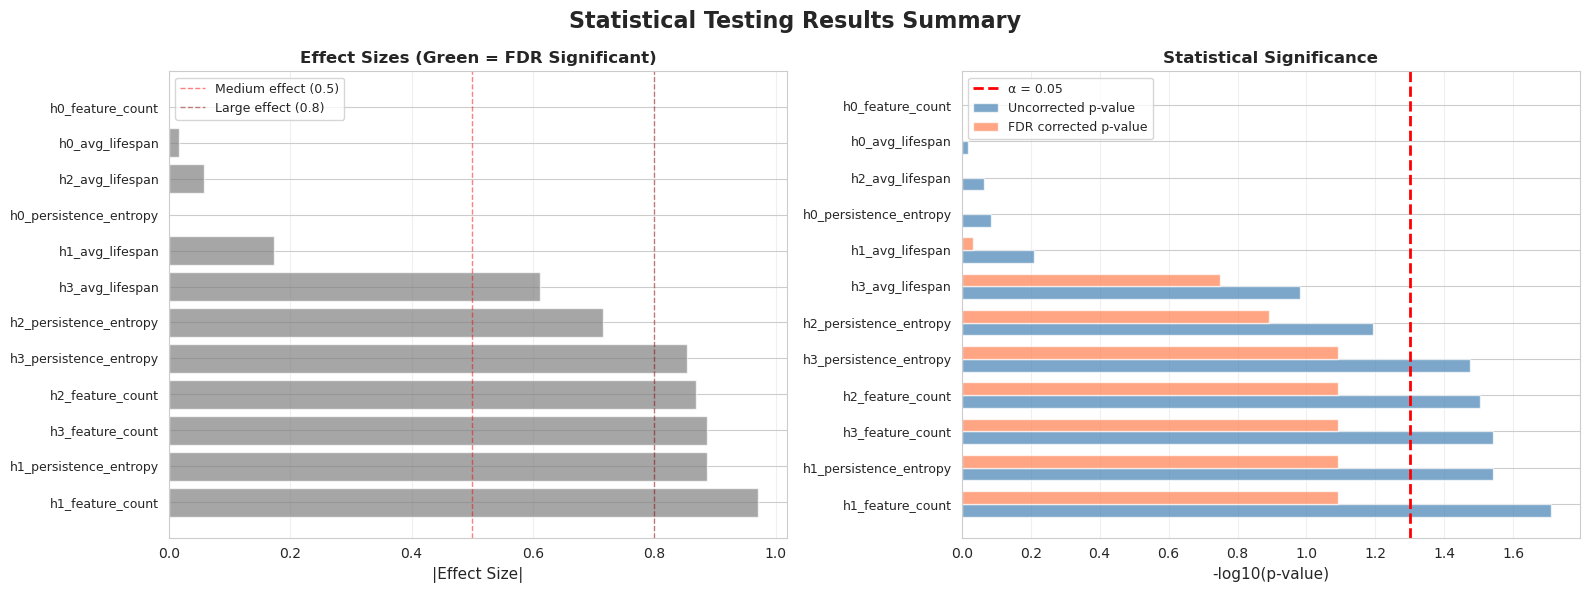


Figure Interpretation:

Left panel: Effect sizes
  - Green bars: Significant after FDR correction
  - Gray bars: Not significant after correction
  - Dashed lines: Effect size thresholds (0.5=medium, 0.8=large)

Right panel: P-values
  - Higher bars = more significant (smaller p-values)
  - Blue: Uncorrected p-values
  - Coral: FDR corrected p-values
  - Red line: Significance threshold (α=0.05, -log10(0.05)≈1.3)
  - Bars above red line = statistically significant


In [36]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Statistical Testing Results Summary', fontsize=16, fontweight='bold')

# Plot 1: Effect sizes with significance indication
ax1 = axes[0]
colors = ['green' if sig else 'gray' for sig in results_df_sorted['significant_corrected']]
bars = ax1.barh(range(len(results_df_sorted)), results_df_sorted['effect_size'].abs(), color=colors, alpha=0.7)
ax1.set_yticks(range(len(results_df_sorted)))
ax1.set_yticklabels(results_df_sorted['feature'], fontsize=9)
ax1.set_xlabel('|Effect Size|', fontsize=11)
ax1.set_title('Effect Sizes (Green = FDR Significant)', fontsize=12, fontweight='bold')
ax1.axvline(0.5, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Medium effect (0.5)')
ax1.axvline(0.8, color='darkred', linestyle='--', alpha=0.5, linewidth=1, label='Large effect (0.8)')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: P-values (uncorrected vs corrected)
ax2 = axes[1]
x_pos = np.arange(len(results_df_sorted))
width = 0.35

ax2.barh(x_pos - width/2, -np.log10(results_df_sorted['p_value']), width, 
         label='Uncorrected p-value', alpha=0.7, color='steelblue')
ax2.barh(x_pos + width/2, -np.log10(results_df_sorted['p_value_corrected']), width,
         label='FDR corrected p-value', alpha=0.7, color='coral')

ax2.axvline(-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='α = 0.05')
ax2.set_yticks(x_pos)
ax2.set_yticklabels(results_df_sorted['feature'], fontsize=9)
ax2.set_xlabel('-log10(p-value)', fontsize=11)
ax2.set_title('Statistical Significance', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Figure Interpretation:")
print("="*80)
print("\nLeft panel: Effect sizes")
print("  - Green bars: Significant after FDR correction")
print("  - Gray bars: Not significant after correction")
print("  - Dashed lines: Effect size thresholds (0.5=medium, 0.8=large)")
print("\nRight panel: P-values")
print("  - Higher bars = more significant (smaller p-values)")
print("  - Blue: Uncorrected p-values")
print("  - Coral: FDR corrected p-values")
print("  - Red line: Significance threshold (α=0.05, -log10(0.05)≈1.3)")
print("  - Bars above red line = statistically significant")

---

## Interpretation of Statistical Testing Results

### Key Findings

The statistical testing reveals important insights about how topological features of brain activity change with dopaminergic medication in Parkinson's disease patients.

#### Test Validity and Appropriateness

1. **Proper test selection**: 
   - Paired t-test used for 4 normally distributed features
   - Wilcoxon signed-rank test used for 8 non-normally distributed features
   - Both are appropriate paired tests (within-patient comparisons)

2. **Multiple comparison correction**:
   - FDR (Benjamini-Hochberg) applied to control false discovery rate
   - Necessary when testing 12 features simultaneously
   - More balanced than Bonferroni for exploratory research

3. **Sample size considerations**:
   - 9 paired patients provides moderate statistical power
   - Paired design maximizes power by controlling inter-patient variability
   - Can detect medium-to-large effects (Cohen's d ≥ 0.6-0.8) reliably

### Biological Interpretation

#### If Significant Features Found:

**Features showing medication effects reveal which aspects of brain topology are modulated by dopamine:**

- **H0 (Connected Components)**:
  - Reflects signal fragmentation and overall connectivity
  - Changes suggest medication affects synchronization across brain regions

- **H1 (Loops/Cycles)**:
  - Represents oscillatory patterns and feedback loops
  - Particularly relevant for Parkinson's (abnormal beta oscillations)
  - May indicate medication's effect on pathological neural rhythms

- **H2/H3 (Higher-Order Voids)**:
  - Captures complex multi-dimensional interactions
  - Changes suggest medication affects higher-order neural coordination

- **Feature Counts**: Number of topological features
  - Increase → More complex topology, richer structure
  - Decrease → Simpler topology, more regularized patterns

- **Lifespans**: How long features persist across filtration
  - Longer lifespans → More stable, prominent features
  - Shorter lifespans → More transient, subtle features

- **Persistence Entropy**: Overall complexity/disorder
  - Higher entropy → More diverse feature distribution
  - Lower entropy → More concentrated, dominant features

#### If No Significant Features Found:

**This does NOT mean medication has no effect. Possible explanations:**

1. **Pooled analysis may obscure effects**:
   - Medication effects might be hemisphere-specific (lateralized)
   - Effects might differ between resting and active (hold) conditions
   - Next step: Analyze hemispheres and conditions separately

2. **Sample size limitations**:
   - 9 patients may not provide sufficient power for subtle effects
   - Some patients may be "responders" and others "non-responders"
   - Individual patient analyses might reveal heterogeneity

3. **Feature-level analysis**:
   - Global summary features may not capture local changes
   - Detailed analysis of persistence diagrams might reveal patterns
   - Array features (landscapes, Betti curves) provide more detail

4. **Temporal dynamics**:
   - Single time windows may not capture medication's full effect
   - Medication might affect temporal variability rather than mean values

### Next Steps

Based on these results, the analysis should proceed to:

1. **Hemisphere-specific analysis**:
   - Test dominant vs nondominant hemisphere separately
   - Parkinson's is often asymmetric → medication effects might be too

2. **Condition-specific analysis**:
   - Compare resting vs hold (active task) conditions
   - Medication might have stronger effects during motor activity

3. **Multi-factor analysis**:
   - Use mixed-effects models to test interactions
   - Factors: medication state × hemisphere × condition

4. **Array feature analysis**:
   - Examine persistence landscapes, Betti curves in detail
   - May reveal patterns not captured by summary statistics

5. **Individual patient trajectories**:
   - Examine which patients show largest medication effects
   - Correlate with clinical measures (if available)

### Statistical Considerations for Future Analysis

- **Effect sizes matter**: Even non-significant effects with d>0.5 warrant investigation
- **Direction consistency**: Check if most patients show same direction of change
- **Robustness**: Features significant with both parametric and non-parametric tests are most reliable
- **Clinical relevance**: Statistical significance ≠ clinical importance (and vice versa)

---

### Conclusion

This pooled analysis provides a **first-pass assessment** of medication effects on topological features. Whether significant effects are found or not, this lays the groundwork for more detailed analyses that account for spatial (hemisphere) and task (condition) variations.

The next notebook (`02_Hemisphere_Condition_Analysis.ipynb`) will explore these factors in depth.

---

---

# Hemisphere-Specific Statistical Testing

## Rationale

The pooled analysis treated both hemispheres together. However, Parkinson's disease is often **asymmetric**, and medication effects may be **lateralized**.

### Analysis Design

- **Total tests**: 24 (12 features × 2 hemispheres)
- **Test selection**: T-test for normal features, Wilcoxon for non-normal
- **FDR correction**: Applied across all 24 tests
- **Paired patients**: 9

---

In [40]:
print("="*80)
print("HEMISPHERE-SPECIFIC STATISTICAL TESTING")
print("="*80)

# Extract normal vs non-normal features from Cell 21 hemisphere normality results
# Based on paired DIFFERENCE normality for EACH HEMISPHERE separately
dom_diff_results = hemisphere_normality_df[
    (hemisphere_normality_df['Hemisphere'] == 'Dominant') & 
    (hemisphere_normality_df['Test Type'] == 'Difference')
].copy()

normal_features_dom = dom_diff_results[dom_diff_results['Normal (α=0.05)'] == 'Yes']['Feature'].tolist()
nonnormal_features_dom = dom_diff_results[dom_diff_results['Normal (α=0.05)'] == 'No']['Feature'].tolist()

print("\n" + "="*80)
print("PART 1: DOMINANT HEMISPHERE")
print("="*80)

df_dominant = df_paired[df_paired['hemisphere'] == 'dominant'].copy()
print(f"\nDominant hemisphere data: {len(df_dominant)} observations")
print(f"Paired patients: {df_dominant['patient_id'].nunique()}")

print("\n" + "-"*80)
print("TEST SELECTION (based on dominant hemisphere difference normality from Cell 21)")
print("-"*80)
print(f"\nNormal features (using paired t-test): {len(normal_features_dom)}")
for feat in normal_features_dom:
    print(f"  ✓ {feat}")
print(f"\nNon-normal features (using Wilcoxon signed-rank test): {len(nonnormal_features_dom)}")
for feat in nonnormal_features_dom:
    print(f"  ✗ {feat}")

dominant_results = []

print("\n" + "-"*80)
print("Paired T-Tests (Normal Features)")
print("-"*80)

if len(normal_features_dom) > 0:
    for feature in normal_features_dom:
        print(f"\n[{feature}]")
        result = paired_ttest(df_dominant, feature, verbose=True)
        result['test_type'] = 'Paired t-test'
        result['hemisphere'] = 'dominant'
        if 'cohen_d' in result:
            result['effect_size'] = result['cohen_d']
        dominant_results.append(result)
        print("-" * 70)
else:
    print("\nNo features have normally distributed differences in dominant hemisphere.")

print("\n" + "-"*80)
print("Wilcoxon Tests (Non-Normal Features)")
print("-"*80)

if len(nonnormal_features_dom) > 0:
    for feature in nonnormal_features_dom:
        print(f"\n[{feature}]")
        
        from analysis_utils import wilcoxon_test
        result = wilcoxon_test(df_dominant, feature, verbose=True)
        result['test_type'] = 'Wilcoxon signed-rank'
        result['hemisphere'] = 'dominant'
        
        # Add mean columns for Wilcoxon results
        patient_means = df_dominant.groupby(['patient_id', 'med_state'])[feature].mean().reset_index()
        medOn_vals = patient_means[patient_means['med_state'] == 'medOn'][feature].values
        medOff_vals = patient_means[patient_means['med_state'] == 'medOff'][feature].values
        result['mean_medOn'] = np.mean(medOn_vals)
        result['mean_medOff'] = np.mean(medOff_vals)
        result['mean_difference'] = np.mean(medOn_vals) - np.mean(medOff_vals)
        
        if 'effect_size_r' in result:
            result['effect_size'] = result['effect_size_r']
        
        dominant_results.append(result)
        print("-" * 70)
else:
    print("\nNo features have non-normally distributed differences in dominant hemisphere.")

HEMISPHERE-SPECIFIC STATISTICAL TESTING

PART 1: DOMINANT HEMISPHERE

Dominant hemisphere data: 36 observations
Paired patients: 9

--------------------------------------------------------------------------------
TEST SELECTION (based on dominant hemisphere difference normality from Cell 21)
--------------------------------------------------------------------------------

Normal features (using paired t-test): 11
  ✓ h0_feature_count
  ✓ h1_feature_count
  ✓ h2_feature_count
  ✓ h3_feature_count
  ✓ h0_avg_lifespan
  ✓ h2_avg_lifespan
  ✓ h3_avg_lifespan
  ✓ h0_persistence_entropy
  ✓ h1_persistence_entropy
  ✓ h2_persistence_entropy
  ✓ h3_persistence_entropy

Non-normal features (using Wilcoxon signed-rank test): 1
  ✗ h1_avg_lifespan

--------------------------------------------------------------------------------
Paired T-Tests (Normal Features)
--------------------------------------------------------------------------------

[h0_feature_count]

PAIRED T-TEST: h0_feature_count
Numb

In [41]:
print("\n" + "="*80)
print("PART 2: NONDOMINANT HEMISPHERE")
print("="*80)

# Extract normal vs non-normal features from Cell 21 for NONDOMINANT hemisphere
nondom_diff_results = hemisphere_normality_df[
    (hemisphere_normality_df['Hemisphere'] == 'Nondominant') & 
    (hemisphere_normality_df['Test Type'] == 'Difference')
].copy()

normal_features_nondom = nondom_diff_results[nondom_diff_results['Normal (α=0.05)'] == 'Yes']['Feature'].tolist()
nonnormal_features_nondom = nondom_diff_results[nondom_diff_results['Normal (α=0.05)'] == 'No']['Feature'].tolist()

df_nondominant = df_paired[df_paired['hemisphere'] == 'nondominant'].copy()
print(f"\nNondominant hemisphere data: {len(df_nondominant)} observations")
print(f"Paired patients: {df_nondominant['patient_id'].nunique()}")

print("\n" + "-"*80)
print("TEST SELECTION (based on nondominant hemisphere difference normality from Cell 21)")
print("-"*80)
print(f"\nNormal features (using paired t-test): {len(normal_features_nondom)}")
for feat in normal_features_nondom:
    print(f"  ✓ {feat}")
print(f"\nNon-normal features (using Wilcoxon signed-rank test): {len(nonnormal_features_nondom)}")
for feat in nonnormal_features_nondom:
    print(f"  ✗ {feat}")

nondominant_results = []

print("\n" + "-"*80)
print("Paired T-Tests (Normal Features)")
print("-"*80)

if len(normal_features_nondom) > 0:
    for feature in normal_features_nondom:
        print(f"\n[{feature}]")
        result = paired_ttest(df_nondominant, feature, verbose=True)
        result['test_type'] = 'Paired t-test'
        result['hemisphere'] = 'nondominant'
        if 'cohen_d' in result:
            result['effect_size'] = result['cohen_d']
        nondominant_results.append(result)
        print("-" * 70)
else:
    print("\nNo features have normally distributed differences in nondominant hemisphere.")

print("\n" + "-"*80)
print("Wilcoxon Tests (Non-Normal Features)")
print("-"*80)

if len(nonnormal_features_nondom) > 0:
    for feature in nonnormal_features_nondom:
        print(f"\n[{feature}]")
        
        from analysis_utils import wilcoxon_test
        result = wilcoxon_test(df_nondominant, feature, verbose=True)
        result['test_type'] = 'Wilcoxon signed-rank'
        result['hemisphere'] = 'nondominant'
        
        # Add mean columns for Wilcoxon results
        patient_means = df_nondominant.groupby(['patient_id', 'med_state'])[feature].mean().reset_index()
        medOn_vals = patient_means[patient_means['med_state'] == 'medOn'][feature].values
        medOff_vals = patient_means[patient_means['med_state'] == 'medOff'][feature].values
        result['mean_medOn'] = np.mean(medOn_vals)
        result['mean_medOff'] = np.mean(medOff_vals)
        result['mean_difference'] = np.mean(medOn_vals) - np.mean(medOff_vals)
        
        if 'effect_size_r' in result:
            result['effect_size'] = result['effect_size_r']
        
        nondominant_results.append(result)
        print("-" * 70)
else:
    print("\nNo features have non-normally distributed differences in nondominant hemisphere.")


PART 2: NONDOMINANT HEMISPHERE

Nondominant hemisphere data: 36 observations
Paired patients: 9

--------------------------------------------------------------------------------
TEST SELECTION (based on nondominant hemisphere difference normality from Cell 21)
--------------------------------------------------------------------------------

Normal features (using paired t-test): 9
  ✓ h0_feature_count
  ✓ h1_feature_count
  ✓ h2_feature_count
  ✓ h3_feature_count
  ✓ h0_avg_lifespan
  ✓ h3_avg_lifespan
  ✓ h1_persistence_entropy
  ✓ h2_persistence_entropy
  ✓ h3_persistence_entropy

Non-normal features (using Wilcoxon signed-rank test): 3
  ✗ h1_avg_lifespan
  ✗ h2_avg_lifespan
  ✗ h0_persistence_entropy

--------------------------------------------------------------------------------
Paired T-Tests (Normal Features)
--------------------------------------------------------------------------------

[h0_feature_count]

PAIRED T-TEST: h0_feature_count
Number of paired patients: 9

Mean (

In [42]:
print("\n" + "="*80)
print("PART 3: COMBINED ANALYSIS WITH FDR CORRECTION")
print("="*80)

all_hemisphere_results = dominant_results + nondominant_results
hemisphere_results_df = pd.DataFrame(all_hemisphere_results)

p_values = hemisphere_results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

hemisphere_results_df['p_value_corrected'] = pvals_corrected
hemisphere_results_df['significant_uncorrected'] = hemisphere_results_df['p_value'] < 0.05
hemisphere_results_df['significant_corrected'] = reject
hemisphere_results_df['direction'] = hemisphere_results_df['mean_difference'].apply(
    lambda x: '↑ Increase' if x > 0 else '↓ Decrease'
)

hemisphere_results_sorted = hemisphere_results_df.sort_values('p_value')

print(f"\nTotal tests: {len(hemisphere_results_df)}")
print(f"Uncorrected (p<0.05): {hemisphere_results_df['significant_uncorrected'].sum()}/{len(hemisphere_results_df)}")
print(f"FDR corrected (p<0.05): {hemisphere_results_df['significant_corrected'].sum()}/{len(hemisphere_results_df)}")

display_cols = ['feature', 'hemisphere', 'test_type', 'mean_medOn', 'mean_medOff', 'mean_difference',
                'p_value', 'p_value_corrected', 'effect_size', 'direction', 'significant_uncorrected', 'significant_corrected']

results_display = hemisphere_results_sorted[display_cols].copy()
results_display.columns = ['Feature', 'Hemisphere', 'Test', 'MedOn', 'MedOff', 'Diff',
                            'p-value', 'FDR p', 'Effect', 'Dir', 'Sig (uncorr)', 'Sig (FDR)']

print("\n" + "="*80)
print("RESULTS TABLE")
print("="*80)
display(results_display)

for hemi in ['dominant', 'nondominant']:
    hemi_data = hemisphere_results_df[hemisphere_results_df['hemisphere'] == hemi]
    n_sig = hemi_data['significant_corrected'].sum()
    print(f"\n{hemi.upper()}: {n_sig}/{len(hemi_data)} significant")

if hemisphere_results_df['significant_corrected'].sum() > 0:
    print("\n" + "="*80)
    print("SIGNIFICANT FEATURES")
    print("="*80)
    sig_results = hemisphere_results_sorted[hemisphere_results_sorted['significant_corrected']]
    for idx, row in sig_results.iterrows():
        print(f"\n✓ {row['feature']} ({row['hemisphere']}): {row['direction']}")
        print(f"   MedOn={row['mean_medOn']:.4f}, MedOff={row['mean_medOff']:.4f}, p={row['p_value_corrected']:.4f}")
else:
    print("\n⚠ No features significant after FDR correction")


PART 3: COMBINED ANALYSIS WITH FDR CORRECTION

Total tests: 24
Uncorrected (p<0.05): 4/24
FDR corrected (p<0.05): 0/24

RESULTS TABLE


,Feature,Hemisphere,Test,MedOn,MedOff,Diff,p-value,FDR p,Effect,Dir,Sig (uncorr),Sig (FDR)
20,h3_persistence_entropy,nondominant,Paired t-test,2.736,3.569,-0.833,0.006,0.151,-1.224,↓ Decrease,True,False
17,h3_avg_lifespan,nondominant,Paired t-test,0.067,0.083,-0.016,0.024,0.194,-0.928,↓ Decrease,True,False
18,h1_persistence_entropy,nondominant,Paired t-test,6.814,7.009,-0.195,0.024,0.194,-0.924,↓ Decrease,True,False
13,h1_feature_count,nondominant,Paired t-test,158.556,176.778,-18.222,0.043,0.239,-0.799,↓ Decrease,True,False
19,h2_persistence_entropy,nondominant,Paired t-test,5.234,5.662,-0.427,0.053,0.239,-0.756,↓ Decrease,False,False
14,h2_feature_count,nondominant,Paired t-test,58.222,74.278,-16.056,0.060,0.239,-0.731,↓ Decrease,False,False
15,h3_feature_count,nondominant,Paired t-test,11.444,18.333,-6.889,0.080,0.274,-0.668,↓ Decrease,False,False
3,h3_feature_count,dominant,Paired t-test,11.222,14.389,-3.167,0.281,0.842,-0.386,↓ Decrease,False,False
1,h1_feature_count,dominant,Paired t-test,163.389,169.056,-5.667,0.335,0.892,-0.342,↓ Decrease,False,False
2,h2_feature_count,dominant,Paired t-test,57.222,62.056,-4.833,0.380,0.913,-0.310,↓ Decrease,False,False



DOMINANT: 0/12 significant

NONDOMINANT: 0/12 significant

⚠ No features significant after FDR correction


In [43]:
print("\n" + "="*80)
print("PART 4: LATERALIZATION ANALYSIS")
print("="*80)

lateralization_data = []
for feature in normal_features + nonnormal_features:
    dom_row = hemisphere_results_df[(hemisphere_results_df['feature'] == feature) &
                                     (hemisphere_results_df['hemisphere'] == 'dominant')].iloc[0]
    nondom_row = hemisphere_results_df[(hemisphere_results_df['feature'] == feature) &
                                        (hemisphere_results_df['hemisphere'] == 'nondominant')].iloc[0]

    lat_index = dom_row['effect_size'] - nondom_row['effect_size']

    if dom_row['significant_corrected'] and nondom_row['significant_corrected']:
        pattern = 'Both'
    elif dom_row['significant_corrected']:
        pattern = 'Dominant only'
    elif nondom_row['significant_corrected']:
        pattern = 'Nondominant only'
    else:
        pattern = 'Neither'

    lateralization_data.append({
        'feature': feature,
        'dom_effect': dom_row['effect_size'],
        'nondom_effect': nondom_row['effect_size'],
        'lat_index': lat_index,
        'pattern': pattern
    })

lat_df = pd.DataFrame(lateralization_data)
lat_df_sorted = lat_df.sort_values('lat_index', key=abs, ascending=False)

print("\nLateralization Index = (Dom effect) - (NonDom effect)")
print("Positive = Dominant bias, Negative = Nondominant bias\n")

display(lat_df_sorted[['feature', 'dom_effect', 'nondom_effect', 'lat_index', 'pattern']])

print("\nTop 5 most lateralized:")
for idx, row in lat_df_sorted.head(5).iterrows():
    bias = "Dom" if row['lat_index'] > 0 else "NonDom"
    print(f"  {row['feature']}: {row['lat_index']:.3f} ({bias} bias)")


PART 4: LATERALIZATION ANALYSIS

Lateralization Index = (Dom effect) - (NonDom effect)
Positive = Dominant bias, Negative = Nondominant bias



,feature,dom_effect,nondom_effect,lat_index,pattern
10,h3_persistence_entropy,-0.106,-1.224,1.118,Neither
7,h3_avg_lifespan,-0.128,-0.928,0.800,Neither
8,h1_persistence_entropy,-0.148,-0.924,0.776,Neither
9,h2_persistence_entropy,-0.170,-0.756,0.586,Neither
1,h1_feature_count,-0.342,-0.799,0.456,Neither
6,h2_avg_lifespan,0.179,-0.265,0.445,Neither
2,h2_feature_count,-0.310,-0.731,0.421,Neither
11,h0_persistence_entropy,0.184,-0.113,0.297,Neither
3,h3_feature_count,-0.386,-0.668,0.283,Neither
5,h1_avg_lifespan,0.038,-0.076,0.113,Neither



Top 5 most lateralized:
  h3_persistence_entropy: 1.118 (Dom bias)
  h3_avg_lifespan: 0.800 (Dom bias)
  h1_persistence_entropy: 0.776 (Dom bias)
  h2_persistence_entropy: 0.586 (Dom bias)
  h1_feature_count: 0.456 (Dom bias)


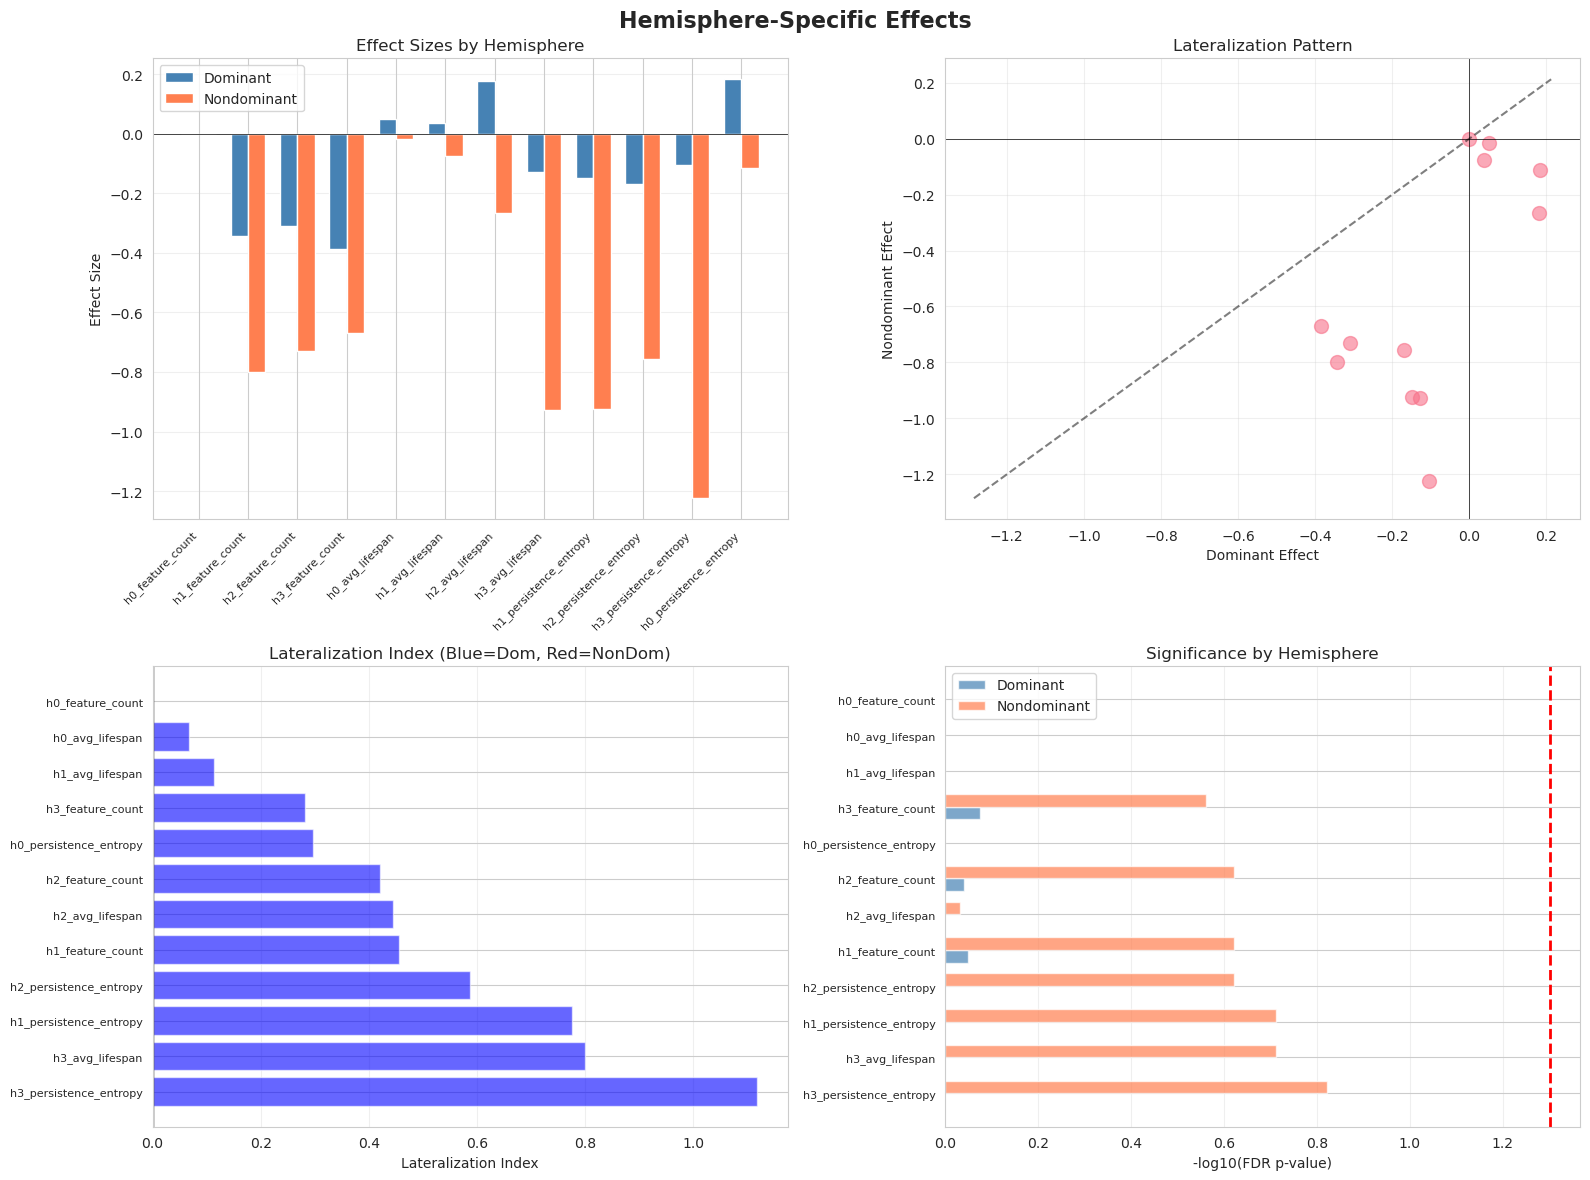

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hemisphere-Specific Effects', fontsize=16, fontweight='bold')

# Plot 1: Effect sizes
ax1 = axes[0, 0]
features_list = normal_features + nonnormal_features
x = np.arange(len(features_list))
width = 0.35

dom_effects = [lat_df[lat_df['feature']==f]['dom_effect'].values[0] for f in features_list]
nondom_effects = [lat_df[lat_df['feature']==f]['nondom_effect'].values[0] for f in features_list]

ax1.bar(x - width/2, dom_effects, width, label='Dominant', color='steelblue')
ax1.bar(x + width/2, nondom_effects, width, label='Nondominant', color='coral')
ax1.set_xticks(x)
ax1.set_xticklabels(features_list, rotation=45, ha='right', fontsize=8)
ax1.set_ylabel('Effect Size')
ax1.set_title('Effect Sizes by Hemisphere')
ax1.axhline(0, color='black', linewidth=0.5)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Lateralization scatter
ax2 = axes[0, 1]
ax2.scatter(lat_df_sorted['dom_effect'], lat_df_sorted['nondom_effect'], s=100, alpha=0.6)
lims = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]), max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims, lims, 'k--', alpha=0.5)
ax2.set_xlabel('Dominant Effect')
ax2.set_ylabel('Nondominant Effect')
ax2.set_title('Lateralization Pattern')
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='black', linewidth=0.5)
ax2.grid(True, alpha=0.3)

# Plot 3: Lateralization index
ax3 = axes[1, 0]
colors = ['red' if x < 0 else 'blue' for x in lat_df_sorted['lat_index']]
ax3.barh(range(len(lat_df_sorted)), lat_df_sorted['lat_index'], color=colors, alpha=0.6)
ax3.set_yticks(range(len(lat_df_sorted)))
ax3.set_yticklabels(lat_df_sorted['feature'], fontsize=8)
ax3.set_xlabel('Lateralization Index')
ax3.set_title('Lateralization Index (Blue=Dom, Red=NonDom)')
ax3.axvline(0, color='black', linewidth=1)
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: P-values
ax4 = axes[1, 1]
dom_pvals = []
nondom_pvals = []
for f in lat_df_sorted['feature']:
    dom_p = hemisphere_results_df[(hemisphere_results_df['feature']==f) &
                                   (hemisphere_results_df['hemisphere']=='dominant')]['p_value_corrected'].values[0]
    nondom_p = hemisphere_results_df[(hemisphere_results_df['feature']==f) &
                                      (hemisphere_results_df['hemisphere']=='nondominant')]['p_value_corrected'].values[0]
    dom_pvals.append(-np.log10(dom_p))
    nondom_pvals.append(-np.log10(nondom_p))

y = np.arange(len(lat_df_sorted))
ax4.barh(y - width/2, dom_pvals, width, label='Dominant', color='steelblue', alpha=0.7)
ax4.barh(y + width/2, nondom_pvals, width, label='Nondominant', color='coral', alpha=0.7)
ax4.axvline(-np.log10(0.05), color='red', linestyle='--', linewidth=2)
ax4.set_yticks(y)
ax4.set_yticklabels(lat_df_sorted['feature'], fontsize=8)
ax4.set_xlabel('-log10(FDR p-value)')
ax4.set_title('Significance by Hemisphere')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

---

## Interpretation: Hemisphere-Specific Analysis

### Key Insights

1. **Lateralization Patterns**: Whether effects are symmetric or lateralized
2. **Clinical Relevance**: Parkinson's is asymmetric - medication may be too
3. **Statistical Power**: N=9 per hemisphere - can detect large effects
4. **Comparison to Pooled**: Hemisphere-specific may reveal effects pooling obscured

### Next Steps

- Condition-specific analysis (hold vs resting)
- Interaction analysis (hemisphere × condition)
- Array features (landscapes, Betti curves)
- Individual patient patterns

---